In [1]:
import numpy as np
import pandas as pd
import random 
from random import randint

import os
import json
from pathlib import Path

import tensorflow.keras as keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt
from matplotlib import colors

In [2]:
data_path = Path('./kaggle_input/')
training_path = data_path / 'training'      # 400 X-train ('train'), y-train('test') input-output pairs
evaluation_path = data_path / 'evaluation'  # 400
test_path = data_path / 'test'              # 100 pairs X-train ('train') (input-output),
                                            #           y-train (input only) pairs

training_tasks_files = sorted(os.listdir(training_path))#[1:]
eval_tasks_files = sorted(os.listdir(evaluation_path))
test_task_files = sorted(os.listdir(test_path))

In [3]:
def load_files(path):
    path_files = sorted(os.listdir(path))
    tasks = []
    for task_file in path_files:
        with open(str(path / task_file), 'r') as f:
            task = json.load(f)
            tasks.append(task)
    return tasks

In [4]:
training_tasks = load_files(training_path)
test_tasks = load_files(test_path)
evaluation_tasks = load_files(evaluation_path)

 
 ---
 ---

### 1. Create Train - Test - Split

In [5]:
def tts():
    Xs_test, ys_test, Xs_train, ys_train = [], [], [], []

    for task in training_tasks:
        X_test, y_test, X_train, y_train = [], [], [], []

        for pair in task["test"]:
            X_test.append(pair["input"])
            y_test.append(pair["output"])      ### to be predicted !!!

        for pair in task["train"]:
            X_train.append(pair["input"])
            y_train.append(pair["output"])

        Xs_test.append(X_test)
        ys_test.append(y_test)
        Xs_train.append(X_train)
        ys_train.append(y_train)
    return Xs_test, ys_test, Xs_train, ys_train

In [6]:
Xs_test_orig, ys_test_orig, Xs_train_orig, ys_train_orig = tts()

In [7]:
len(Xs_train_orig), len(ys_train_orig), len(Xs_test_orig), len(ys_test_orig)

(400, 400, 400, 400)

In [8]:
len(Xs_train_orig[0]), len(ys_train_orig[0]), len(Xs_test_orig[0]), len(ys_test_orig[0])

(5, 5, 1, 1)

In [9]:
Xs_test, ys_test, Xs_train, ys_train = tts()

In [10]:
len(Xs_train), len(ys_train), len(Xs_test), len(ys_test)

(400, 400, 400, 400)

In [61]:
len(Xs_train[2]), len(ys_train[2]), len(Xs_test[2]), len(ys_test[2])

(3, 3, 1, 1)

In [12]:
def prep_tasks(split_list):
    split_tasks = []
    for task in split_list:
        li=[]
        for e in task:
            e = np.array(e)
            e = np.pad(e, [(0, 32-e.shape[0]), (0, 32-e.shape[1])], mode='constant')
            e = e / 10.
            e = e.reshape(e.shape + (1,) )
            li.append(e)
#         li = np.array(li)
        split_tasks.append(li)
    return split_tasks

In [13]:
Xs_train_tasks = prep_tasks(Xs_train)
Xs_test_tasks = prep_tasks(Xs_test)
ys_train_tasks = prep_tasks(ys_train)
ys_test_tasks = prep_tasks(ys_test)



In [14]:
len(Xs_train), len(ys_train), len(Xs_test), len(ys_test)

(400, 400, 400, 400)

In [15]:
len(Xs_train[0]), len(ys_train[0]), len(Xs_test[0]), len(ys_test[0])

(5, 5, 1, 1)

In [16]:
# Xs_train_tasks[0].shape,ys_train_tasks[0].shape, Xs_test_tasks[0].shape, ys_test_tasks[0].shape

## Data Augmentation of the training data

In [17]:
#### color
def color_change(arr):
    x = arr*2
    x = x/x.max()
    x = np.ndarray.round(x,1)
    return x

In [18]:
r = (np.array([[0,2,2],[2,0,0],[6,4,6]]))/10
r

array([[0. , 0.2, 0.2],
       [0.2, 0. , 0. ],
       [0.6, 0.4, 0.6]])

In [19]:
r.max()

0.6

In [20]:
color_change(r)

array([[0. , 0.3, 0.3],
       [0.3, 0. , 0. ],
       [1. , 0.7, 1. ]])

In [21]:
# my_list = [np.fliplr, np.flipud, np.rot90]
# method = random.choice(my_list)
# method(arr1)
# method(arr2)

In [22]:
def augm(X_list, y_list):
    idx = 1
    X_list_new = X_list
    y_list_new = y_list
    
    for task_X, task_y in zip(X_list, y_list):
        print("TASK",idx)
        
        while len(task_X) < 100:
            
            """
            choose a random method and append new array
            """
            i = randint(0,len(task_X)-1) 
            new_x = task_X[i]
            new_y = task_y[i]
            
            
            times = randint(1,11)
            print(f"LENGTH: {len(task_X)} // INDEX: {i} // TIMES: {times}" )
            for j in range(times):
                
                method = random.choice([np.fliplr, np.flipud, np.rot90,color_change])
                new_x = method(new_x)
                new_y = method(new_y)
#                 print(j)

            
            task_X.append(new_x)
            task_y.append(new_y)
            
#             task_X = np.append(task_X,new_x, axis=1)
#             task_y = np.append(task_y,new_y, axis=1)
            
#             print(f"LENGTH: {len(task_X)}")
        idx +=1
    return task_X,task_y

In [23]:
augm(Xs_train_tasks, ys_train_tasks)

TASK 1
LENGTH: 5 // INDEX: 2 // TIMES: 4
LENGTH: 6 // INDEX: 3 // TIMES: 6
LENGTH: 7 // INDEX: 0 // TIMES: 1
LENGTH: 8 // INDEX: 3 // TIMES: 11
LENGTH: 9 // INDEX: 8 // TIMES: 2
LENGTH: 10 // INDEX: 2 // TIMES: 1
LENGTH: 11 // INDEX: 0 // TIMES: 3
LENGTH: 12 // INDEX: 1 // TIMES: 1
LENGTH: 13 // INDEX: 5 // TIMES: 11
LENGTH: 14 // INDEX: 8 // TIMES: 11
LENGTH: 15 // INDEX: 12 // TIMES: 9
LENGTH: 16 // INDEX: 14 // TIMES: 4
LENGTH: 17 // INDEX: 9 // TIMES: 9
LENGTH: 18 // INDEX: 1 // TIMES: 7
LENGTH: 19 // INDEX: 10 // TIMES: 8
LENGTH: 20 // INDEX: 19 // TIMES: 3
LENGTH: 21 // INDEX: 15 // TIMES: 8
LENGTH: 22 // INDEX: 20 // TIMES: 2
LENGTH: 23 // INDEX: 11 // TIMES: 10
LENGTH: 24 // INDEX: 10 // TIMES: 6
LENGTH: 25 // INDEX: 15 // TIMES: 9
LENGTH: 26 // INDEX: 2 // TIMES: 10
LENGTH: 27 // INDEX: 15 // TIMES: 10
LENGTH: 28 // INDEX: 26 // TIMES: 4
LENGTH: 29 // INDEX: 0 // TIMES: 9
LENGTH: 30 // INDEX: 6 // TIMES: 1
LENGTH: 31 // INDEX: 12 // TIMES: 5
LENGTH: 32 // INDEX: 16 // TIMES: 4

LENGTH: 15 // INDEX: 12 // TIMES: 11
LENGTH: 16 // INDEX: 3 // TIMES: 3
LENGTH: 17 // INDEX: 10 // TIMES: 1
LENGTH: 18 // INDEX: 9 // TIMES: 6
LENGTH: 19 // INDEX: 16 // TIMES: 1
LENGTH: 20 // INDEX: 9 // TIMES: 9
LENGTH: 21 // INDEX: 4 // TIMES: 11
LENGTH: 22 // INDEX: 3 // TIMES: 5
LENGTH: 23 // INDEX: 11 // TIMES: 10
LENGTH: 24 // INDEX: 5 // TIMES: 9
LENGTH: 25 // INDEX: 11 // TIMES: 9
LENGTH: 26 // INDEX: 5 // TIMES: 7
LENGTH: 27 // INDEX: 12 // TIMES: 1
LENGTH: 28 // INDEX: 4 // TIMES: 9
LENGTH: 29 // INDEX: 10 // TIMES: 5
LENGTH: 30 // INDEX: 19 // TIMES: 5
LENGTH: 31 // INDEX: 8 // TIMES: 6
LENGTH: 32 // INDEX: 5 // TIMES: 9
LENGTH: 33 // INDEX: 2 // TIMES: 11
LENGTH: 34 // INDEX: 1 // TIMES: 8
LENGTH: 35 // INDEX: 0 // TIMES: 7
LENGTH: 36 // INDEX: 20 // TIMES: 8
LENGTH: 37 // INDEX: 36 // TIMES: 11
LENGTH: 38 // INDEX: 11 // TIMES: 4
LENGTH: 39 // INDEX: 38 // TIMES: 8
LENGTH: 40 // INDEX: 31 // TIMES: 2
LENGTH: 41 // INDEX: 17 // TIMES: 7
LENGTH: 42 // INDEX: 27 // TIMES: 7


LENGTH: 93 // INDEX: 70 // TIMES: 7
LENGTH: 94 // INDEX: 89 // TIMES: 7
LENGTH: 95 // INDEX: 43 // TIMES: 10
LENGTH: 96 // INDEX: 29 // TIMES: 8
LENGTH: 97 // INDEX: 23 // TIMES: 3
LENGTH: 98 // INDEX: 43 // TIMES: 7
LENGTH: 99 // INDEX: 19 // TIMES: 3
TASK 9
LENGTH: 3 // INDEX: 2 // TIMES: 8
LENGTH: 4 // INDEX: 1 // TIMES: 3
LENGTH: 5 // INDEX: 0 // TIMES: 10
LENGTH: 6 // INDEX: 5 // TIMES: 4
LENGTH: 7 // INDEX: 0 // TIMES: 4
LENGTH: 8 // INDEX: 2 // TIMES: 1
LENGTH: 9 // INDEX: 8 // TIMES: 10
LENGTH: 10 // INDEX: 2 // TIMES: 10
LENGTH: 11 // INDEX: 4 // TIMES: 6
LENGTH: 12 // INDEX: 1 // TIMES: 3
LENGTH: 13 // INDEX: 8 // TIMES: 11
LENGTH: 14 // INDEX: 9 // TIMES: 2
LENGTH: 15 // INDEX: 8 // TIMES: 6
LENGTH: 16 // INDEX: 2 // TIMES: 7
LENGTH: 17 // INDEX: 16 // TIMES: 4
LENGTH: 18 // INDEX: 11 // TIMES: 9
LENGTH: 19 // INDEX: 3 // TIMES: 6
LENGTH: 20 // INDEX: 1 // TIMES: 1
LENGTH: 21 // INDEX: 17 // TIMES: 7
LENGTH: 22 // INDEX: 12 // TIMES: 11
LENGTH: 23 // INDEX: 7 // TIMES: 10
LE

LENGTH: 82 // INDEX: 66 // TIMES: 7
LENGTH: 83 // INDEX: 59 // TIMES: 2
LENGTH: 84 // INDEX: 67 // TIMES: 5
LENGTH: 85 // INDEX: 34 // TIMES: 8
LENGTH: 86 // INDEX: 34 // TIMES: 11
LENGTH: 87 // INDEX: 69 // TIMES: 8
LENGTH: 88 // INDEX: 57 // TIMES: 4
LENGTH: 89 // INDEX: 43 // TIMES: 6
LENGTH: 90 // INDEX: 59 // TIMES: 1
LENGTH: 91 // INDEX: 4 // TIMES: 8
LENGTH: 92 // INDEX: 24 // TIMES: 7
LENGTH: 93 // INDEX: 89 // TIMES: 3
LENGTH: 94 // INDEX: 50 // TIMES: 4
LENGTH: 95 // INDEX: 29 // TIMES: 9
LENGTH: 96 // INDEX: 14 // TIMES: 1
LENGTH: 97 // INDEX: 93 // TIMES: 10
LENGTH: 98 // INDEX: 42 // TIMES: 11
LENGTH: 99 // INDEX: 28 // TIMES: 7
TASK 14
LENGTH: 3 // INDEX: 2 // TIMES: 11
LENGTH: 4 // INDEX: 0 // TIMES: 5
LENGTH: 5 // INDEX: 4 // TIMES: 8
LENGTH: 6 // INDEX: 1 // TIMES: 1
LENGTH: 7 // INDEX: 4 // TIMES: 3
LENGTH: 8 // INDEX: 1 // TIMES: 2
LENGTH: 9 // INDEX: 6 // TIMES: 10
LENGTH: 10 // INDEX: 1 // TIMES: 5
LENGTH: 11 // INDEX: 5 // TIMES: 2
LENGTH: 12 // INDEX: 3 // TIMES:

LENGTH: 69 // INDEX: 67 // TIMES: 2
LENGTH: 70 // INDEX: 43 // TIMES: 8
LENGTH: 71 // INDEX: 5 // TIMES: 8
LENGTH: 72 // INDEX: 6 // TIMES: 5
LENGTH: 73 // INDEX: 59 // TIMES: 5
LENGTH: 74 // INDEX: 15 // TIMES: 9
LENGTH: 75 // INDEX: 58 // TIMES: 1
LENGTH: 76 // INDEX: 75 // TIMES: 2
LENGTH: 77 // INDEX: 37 // TIMES: 10
LENGTH: 78 // INDEX: 50 // TIMES: 9
LENGTH: 79 // INDEX: 12 // TIMES: 10
LENGTH: 80 // INDEX: 23 // TIMES: 10
LENGTH: 81 // INDEX: 12 // TIMES: 3
LENGTH: 82 // INDEX: 47 // TIMES: 10
LENGTH: 83 // INDEX: 14 // TIMES: 2
LENGTH: 84 // INDEX: 53 // TIMES: 3
LENGTH: 85 // INDEX: 78 // TIMES: 9
LENGTH: 86 // INDEX: 29 // TIMES: 10
LENGTH: 87 // INDEX: 69 // TIMES: 11
LENGTH: 88 // INDEX: 57 // TIMES: 3
LENGTH: 89 // INDEX: 17 // TIMES: 7
LENGTH: 90 // INDEX: 83 // TIMES: 8
LENGTH: 91 // INDEX: 84 // TIMES: 8
LENGTH: 92 // INDEX: 69 // TIMES: 2
LENGTH: 93 // INDEX: 2 // TIMES: 2
LENGTH: 94 // INDEX: 17 // TIMES: 6
LENGTH: 95 // INDEX: 8 // TIMES: 8
LENGTH: 96 // INDEX: 8 // 

LENGTH: 67 // INDEX: 63 // TIMES: 10
LENGTH: 68 // INDEX: 28 // TIMES: 9
LENGTH: 69 // INDEX: 0 // TIMES: 1
LENGTH: 70 // INDEX: 24 // TIMES: 2
LENGTH: 71 // INDEX: 47 // TIMES: 2
LENGTH: 72 // INDEX: 29 // TIMES: 6
LENGTH: 73 // INDEX: 67 // TIMES: 5
LENGTH: 74 // INDEX: 4 // TIMES: 2
LENGTH: 75 // INDEX: 48 // TIMES: 3
LENGTH: 76 // INDEX: 25 // TIMES: 9
LENGTH: 77 // INDEX: 14 // TIMES: 8
LENGTH: 78 // INDEX: 68 // TIMES: 9
LENGTH: 79 // INDEX: 34 // TIMES: 11
LENGTH: 80 // INDEX: 73 // TIMES: 1
LENGTH: 81 // INDEX: 73 // TIMES: 7
LENGTH: 82 // INDEX: 74 // TIMES: 9
LENGTH: 83 // INDEX: 24 // TIMES: 6
LENGTH: 84 // INDEX: 41 // TIMES: 11
LENGTH: 85 // INDEX: 47 // TIMES: 11
LENGTH: 86 // INDEX: 5 // TIMES: 10
LENGTH: 87 // INDEX: 34 // TIMES: 10
LENGTH: 88 // INDEX: 67 // TIMES: 6
LENGTH: 89 // INDEX: 4 // TIMES: 7
LENGTH: 90 // INDEX: 78 // TIMES: 6
LENGTH: 91 // INDEX: 37 // TIMES: 4
LENGTH: 92 // INDEX: 46 // TIMES: 1
LENGTH: 93 // INDEX: 73 // TIMES: 2
LENGTH: 94 // INDEX: 54 //

LENGTH: 34 // INDEX: 25 // TIMES: 4
LENGTH: 35 // INDEX: 2 // TIMES: 10
LENGTH: 36 // INDEX: 17 // TIMES: 5
LENGTH: 37 // INDEX: 17 // TIMES: 4
LENGTH: 38 // INDEX: 36 // TIMES: 1
LENGTH: 39 // INDEX: 25 // TIMES: 7
LENGTH: 40 // INDEX: 33 // TIMES: 9
LENGTH: 41 // INDEX: 40 // TIMES: 10
LENGTH: 42 // INDEX: 29 // TIMES: 7
LENGTH: 43 // INDEX: 30 // TIMES: 3
LENGTH: 44 // INDEX: 24 // TIMES: 1
LENGTH: 45 // INDEX: 22 // TIMES: 4
LENGTH: 46 // INDEX: 40 // TIMES: 6
LENGTH: 47 // INDEX: 9 // TIMES: 10
LENGTH: 48 // INDEX: 21 // TIMES: 2
LENGTH: 49 // INDEX: 23 // TIMES: 10
LENGTH: 50 // INDEX: 30 // TIMES: 9
LENGTH: 51 // INDEX: 48 // TIMES: 8
LENGTH: 52 // INDEX: 11 // TIMES: 4
LENGTH: 53 // INDEX: 2 // TIMES: 5
LENGTH: 54 // INDEX: 17 // TIMES: 8
LENGTH: 55 // INDEX: 28 // TIMES: 2
LENGTH: 56 // INDEX: 20 // TIMES: 5
LENGTH: 57 // INDEX: 6 // TIMES: 2
LENGTH: 58 // INDEX: 9 // TIMES: 10
LENGTH: 59 // INDEX: 2 // TIMES: 8
LENGTH: 60 // INDEX: 4 // TIMES: 4
LENGTH: 61 // INDEX: 51 // TIM

LENGTH: 81 // INDEX: 63 // TIMES: 2
LENGTH: 82 // INDEX: 62 // TIMES: 5
LENGTH: 83 // INDEX: 12 // TIMES: 7
LENGTH: 84 // INDEX: 43 // TIMES: 2
LENGTH: 85 // INDEX: 70 // TIMES: 1
LENGTH: 86 // INDEX: 0 // TIMES: 8
LENGTH: 87 // INDEX: 6 // TIMES: 11
LENGTH: 88 // INDEX: 8 // TIMES: 8
LENGTH: 89 // INDEX: 73 // TIMES: 5
LENGTH: 90 // INDEX: 54 // TIMES: 11
LENGTH: 91 // INDEX: 88 // TIMES: 7
LENGTH: 92 // INDEX: 76 // TIMES: 4
LENGTH: 93 // INDEX: 37 // TIMES: 3
LENGTH: 94 // INDEX: 67 // TIMES: 8
LENGTH: 95 // INDEX: 59 // TIMES: 9
LENGTH: 96 // INDEX: 77 // TIMES: 6
LENGTH: 97 // INDEX: 85 // TIMES: 1
LENGTH: 98 // INDEX: 87 // TIMES: 2
LENGTH: 99 // INDEX: 19 // TIMES: 7
TASK 32
LENGTH: 3 // INDEX: 1 // TIMES: 1
LENGTH: 4 // INDEX: 2 // TIMES: 3
LENGTH: 5 // INDEX: 3 // TIMES: 6
LENGTH: 6 // INDEX: 2 // TIMES: 7
LENGTH: 7 // INDEX: 3 // TIMES: 6
LENGTH: 8 // INDEX: 0 // TIMES: 9
LENGTH: 9 // INDEX: 4 // TIMES: 10
LENGTH: 10 // INDEX: 1 // TIMES: 9
LENGTH: 11 // INDEX: 1 // TIMES: 9


LENGTH: 73 // INDEX: 35 // TIMES: 5
LENGTH: 74 // INDEX: 20 // TIMES: 11
LENGTH: 75 // INDEX: 25 // TIMES: 4
LENGTH: 76 // INDEX: 36 // TIMES: 3
LENGTH: 77 // INDEX: 16 // TIMES: 8
LENGTH: 78 // INDEX: 46 // TIMES: 6
LENGTH: 79 // INDEX: 31 // TIMES: 9
LENGTH: 80 // INDEX: 37 // TIMES: 4
LENGTH: 81 // INDEX: 62 // TIMES: 3
LENGTH: 82 // INDEX: 60 // TIMES: 4
LENGTH: 83 // INDEX: 69 // TIMES: 1
LENGTH: 84 // INDEX: 48 // TIMES: 10
LENGTH: 85 // INDEX: 40 // TIMES: 6
LENGTH: 86 // INDEX: 58 // TIMES: 1
LENGTH: 87 // INDEX: 64 // TIMES: 9
LENGTH: 88 // INDEX: 80 // TIMES: 8
LENGTH: 89 // INDEX: 77 // TIMES: 8
LENGTH: 90 // INDEX: 38 // TIMES: 6
LENGTH: 91 // INDEX: 30 // TIMES: 2
LENGTH: 92 // INDEX: 70 // TIMES: 4
LENGTH: 93 // INDEX: 1 // TIMES: 9
LENGTH: 94 // INDEX: 61 // TIMES: 5
LENGTH: 95 // INDEX: 0 // TIMES: 5
LENGTH: 96 // INDEX: 56 // TIMES: 6
LENGTH: 97 // INDEX: 18 // TIMES: 10
LENGTH: 98 // INDEX: 29 // TIMES: 11
LENGTH: 99 // INDEX: 18 // TIMES: 11
TASK 36
LENGTH: 2 // INDE

LENGTH: 39 // INDEX: 16 // TIMES: 7
LENGTH: 40 // INDEX: 37 // TIMES: 5
LENGTH: 41 // INDEX: 26 // TIMES: 9
LENGTH: 42 // INDEX: 38 // TIMES: 7
LENGTH: 43 // INDEX: 11 // TIMES: 3
LENGTH: 44 // INDEX: 2 // TIMES: 3
LENGTH: 45 // INDEX: 28 // TIMES: 2
LENGTH: 46 // INDEX: 35 // TIMES: 2
LENGTH: 47 // INDEX: 20 // TIMES: 6
LENGTH: 48 // INDEX: 14 // TIMES: 8
LENGTH: 49 // INDEX: 9 // TIMES: 9
LENGTH: 50 // INDEX: 23 // TIMES: 1
LENGTH: 51 // INDEX: 28 // TIMES: 6
LENGTH: 52 // INDEX: 41 // TIMES: 7
LENGTH: 53 // INDEX: 26 // TIMES: 10
LENGTH: 54 // INDEX: 40 // TIMES: 9
LENGTH: 55 // INDEX: 46 // TIMES: 3
LENGTH: 56 // INDEX: 28 // TIMES: 1
LENGTH: 57 // INDEX: 35 // TIMES: 10
LENGTH: 58 // INDEX: 4 // TIMES: 7
LENGTH: 59 // INDEX: 28 // TIMES: 1
LENGTH: 60 // INDEX: 12 // TIMES: 11
LENGTH: 61 // INDEX: 18 // TIMES: 8
LENGTH: 62 // INDEX: 39 // TIMES: 6
LENGTH: 63 // INDEX: 62 // TIMES: 11
LENGTH: 64 // INDEX: 0 // TIMES: 8
LENGTH: 65 // INDEX: 40 // TIMES: 1
LENGTH: 66 // INDEX: 12 // T

LENGTH: 5 // INDEX: 3 // TIMES: 8
LENGTH: 6 // INDEX: 2 // TIMES: 8
LENGTH: 7 // INDEX: 6 // TIMES: 5
LENGTH: 8 // INDEX: 7 // TIMES: 7
LENGTH: 9 // INDEX: 8 // TIMES: 11
LENGTH: 10 // INDEX: 8 // TIMES: 8
LENGTH: 11 // INDEX: 6 // TIMES: 1
LENGTH: 12 // INDEX: 11 // TIMES: 1
LENGTH: 13 // INDEX: 1 // TIMES: 8
LENGTH: 14 // INDEX: 13 // TIMES: 7
LENGTH: 15 // INDEX: 5 // TIMES: 7
LENGTH: 16 // INDEX: 0 // TIMES: 10
LENGTH: 17 // INDEX: 8 // TIMES: 1
LENGTH: 18 // INDEX: 0 // TIMES: 1
LENGTH: 19 // INDEX: 2 // TIMES: 5
LENGTH: 20 // INDEX: 8 // TIMES: 6
LENGTH: 21 // INDEX: 12 // TIMES: 3
LENGTH: 22 // INDEX: 12 // TIMES: 2
LENGTH: 23 // INDEX: 5 // TIMES: 9
LENGTH: 24 // INDEX: 9 // TIMES: 5
LENGTH: 25 // INDEX: 14 // TIMES: 4
LENGTH: 26 // INDEX: 25 // TIMES: 7
LENGTH: 27 // INDEX: 18 // TIMES: 7
LENGTH: 28 // INDEX: 27 // TIMES: 8
LENGTH: 29 // INDEX: 9 // TIMES: 8
LENGTH: 30 // INDEX: 18 // TIMES: 1
LENGTH: 31 // INDEX: 11 // TIMES: 2
LENGTH: 32 // INDEX: 19 // TIMES: 9
LENGTH: 33 /

LENGTH: 81 // INDEX: 65 // TIMES: 9
LENGTH: 82 // INDEX: 2 // TIMES: 6
LENGTH: 83 // INDEX: 41 // TIMES: 9
LENGTH: 84 // INDEX: 6 // TIMES: 9
LENGTH: 85 // INDEX: 68 // TIMES: 4
LENGTH: 86 // INDEX: 65 // TIMES: 5
LENGTH: 87 // INDEX: 1 // TIMES: 1
LENGTH: 88 // INDEX: 41 // TIMES: 5
LENGTH: 89 // INDEX: 6 // TIMES: 7
LENGTH: 90 // INDEX: 61 // TIMES: 9
LENGTH: 91 // INDEX: 81 // TIMES: 3
LENGTH: 92 // INDEX: 18 // TIMES: 5
LENGTH: 93 // INDEX: 35 // TIMES: 2
LENGTH: 94 // INDEX: 49 // TIMES: 5
LENGTH: 95 // INDEX: 22 // TIMES: 11
LENGTH: 96 // INDEX: 40 // TIMES: 3
LENGTH: 97 // INDEX: 35 // TIMES: 4
LENGTH: 98 // INDEX: 40 // TIMES: 4
LENGTH: 99 // INDEX: 19 // TIMES: 10
TASK 48
LENGTH: 6 // INDEX: 2 // TIMES: 6
LENGTH: 7 // INDEX: 3 // TIMES: 1
LENGTH: 8 // INDEX: 3 // TIMES: 2
LENGTH: 9 // INDEX: 0 // TIMES: 1
LENGTH: 10 // INDEX: 9 // TIMES: 6
LENGTH: 11 // INDEX: 10 // TIMES: 8
LENGTH: 12 // INDEX: 1 // TIMES: 8
LENGTH: 13 // INDEX: 5 // TIMES: 11
LENGTH: 14 // INDEX: 8 // TIMES:

/opt/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


LENGTH: 26 // INDEX: 21 // TIMES: 1
LENGTH: 27 // INDEX: 18 // TIMES: 9
LENGTH: 28 // INDEX: 1 // TIMES: 8
LENGTH: 29 // INDEX: 20 // TIMES: 3
LENGTH: 30 // INDEX: 27 // TIMES: 11
LENGTH: 31 // INDEX: 12 // TIMES: 4
LENGTH: 32 // INDEX: 24 // TIMES: 9
LENGTH: 33 // INDEX: 31 // TIMES: 10
LENGTH: 34 // INDEX: 29 // TIMES: 2
LENGTH: 35 // INDEX: 29 // TIMES: 10
LENGTH: 36 // INDEX: 26 // TIMES: 2
LENGTH: 37 // INDEX: 24 // TIMES: 10
LENGTH: 38 // INDEX: 5 // TIMES: 3
LENGTH: 39 // INDEX: 22 // TIMES: 1
LENGTH: 40 // INDEX: 36 // TIMES: 2
LENGTH: 41 // INDEX: 10 // TIMES: 3
LENGTH: 42 // INDEX: 22 // TIMES: 5
LENGTH: 43 // INDEX: 36 // TIMES: 3
LENGTH: 44 // INDEX: 4 // TIMES: 7
LENGTH: 45 // INDEX: 12 // TIMES: 2
LENGTH: 46 // INDEX: 24 // TIMES: 4
LENGTH: 47 // INDEX: 22 // TIMES: 3
LENGTH: 48 // INDEX: 40 // TIMES: 1
LENGTH: 49 // INDEX: 48 // TIMES: 9
LENGTH: 50 // INDEX: 44 // TIMES: 3
LENGTH: 51 // INDEX: 47 // TIMES: 4
LENGTH: 52 // INDEX: 47 // TIMES: 8
LENGTH: 53 // INDEX: 28 // 

LENGTH: 85 // INDEX: 63 // TIMES: 3
LENGTH: 86 // INDEX: 55 // TIMES: 1
LENGTH: 87 // INDEX: 79 // TIMES: 7
LENGTH: 88 // INDEX: 44 // TIMES: 4
LENGTH: 89 // INDEX: 15 // TIMES: 2
LENGTH: 90 // INDEX: 78 // TIMES: 8
LENGTH: 91 // INDEX: 2 // TIMES: 4
LENGTH: 92 // INDEX: 29 // TIMES: 10
LENGTH: 93 // INDEX: 7 // TIMES: 8
LENGTH: 94 // INDEX: 93 // TIMES: 6
LENGTH: 95 // INDEX: 51 // TIMES: 9
LENGTH: 96 // INDEX: 67 // TIMES: 2
LENGTH: 97 // INDEX: 26 // TIMES: 2
LENGTH: 98 // INDEX: 95 // TIMES: 9
LENGTH: 99 // INDEX: 66 // TIMES: 2
TASK 56
LENGTH: 7 // INDEX: 6 // TIMES: 7
LENGTH: 8 // INDEX: 3 // TIMES: 3
LENGTH: 9 // INDEX: 5 // TIMES: 6
LENGTH: 10 // INDEX: 9 // TIMES: 11
LENGTH: 11 // INDEX: 8 // TIMES: 4
LENGTH: 12 // INDEX: 7 // TIMES: 3
LENGTH: 13 // INDEX: 12 // TIMES: 11
LENGTH: 14 // INDEX: 0 // TIMES: 8
LENGTH: 15 // INDEX: 13 // TIMES: 4
LENGTH: 16 // INDEX: 13 // TIMES: 3
LENGTH: 17 // INDEX: 14 // TIMES: 4
LENGTH: 18 // INDEX: 4 // TIMES: 4
LENGTH: 19 // INDEX: 7 // TIME

LENGTH: 82 // INDEX: 28 // TIMES: 8
LENGTH: 83 // INDEX: 56 // TIMES: 1
LENGTH: 84 // INDEX: 66 // TIMES: 7
LENGTH: 85 // INDEX: 76 // TIMES: 7
LENGTH: 86 // INDEX: 11 // TIMES: 11
LENGTH: 87 // INDEX: 8 // TIMES: 6
LENGTH: 88 // INDEX: 69 // TIMES: 2
LENGTH: 89 // INDEX: 62 // TIMES: 9
LENGTH: 90 // INDEX: 63 // TIMES: 3
LENGTH: 91 // INDEX: 11 // TIMES: 9
LENGTH: 92 // INDEX: 26 // TIMES: 7
LENGTH: 93 // INDEX: 31 // TIMES: 1
LENGTH: 94 // INDEX: 2 // TIMES: 10
LENGTH: 95 // INDEX: 16 // TIMES: 5
LENGTH: 96 // INDEX: 76 // TIMES: 4
LENGTH: 97 // INDEX: 79 // TIMES: 6
LENGTH: 98 // INDEX: 72 // TIMES: 4
LENGTH: 99 // INDEX: 82 // TIMES: 1
TASK 61
LENGTH: 4 // INDEX: 2 // TIMES: 6
LENGTH: 5 // INDEX: 1 // TIMES: 3
LENGTH: 6 // INDEX: 2 // TIMES: 9
LENGTH: 7 // INDEX: 0 // TIMES: 10
LENGTH: 8 // INDEX: 7 // TIMES: 11
LENGTH: 9 // INDEX: 6 // TIMES: 2
LENGTH: 10 // INDEX: 8 // TIMES: 1
LENGTH: 11 // INDEX: 3 // TIMES: 8
LENGTH: 12 // INDEX: 0 // TIMES: 7
LENGTH: 13 // INDEX: 0 // TIMES: 

LENGTH: 7 // INDEX: 6 // TIMES: 6
LENGTH: 8 // INDEX: 0 // TIMES: 6
LENGTH: 9 // INDEX: 8 // TIMES: 6
LENGTH: 10 // INDEX: 8 // TIMES: 2
LENGTH: 11 // INDEX: 4 // TIMES: 10
LENGTH: 12 // INDEX: 4 // TIMES: 6
LENGTH: 13 // INDEX: 10 // TIMES: 4
LENGTH: 14 // INDEX: 11 // TIMES: 3
LENGTH: 15 // INDEX: 0 // TIMES: 7
LENGTH: 16 // INDEX: 8 // TIMES: 1
LENGTH: 17 // INDEX: 9 // TIMES: 1
LENGTH: 18 // INDEX: 0 // TIMES: 4
LENGTH: 19 // INDEX: 2 // TIMES: 1
LENGTH: 20 // INDEX: 16 // TIMES: 11
LENGTH: 21 // INDEX: 15 // TIMES: 10
LENGTH: 22 // INDEX: 2 // TIMES: 6
LENGTH: 23 // INDEX: 22 // TIMES: 4
LENGTH: 24 // INDEX: 15 // TIMES: 10
LENGTH: 25 // INDEX: 20 // TIMES: 6
LENGTH: 26 // INDEX: 20 // TIMES: 1
LENGTH: 27 // INDEX: 11 // TIMES: 9
LENGTH: 28 // INDEX: 12 // TIMES: 9
LENGTH: 29 // INDEX: 20 // TIMES: 4
LENGTH: 30 // INDEX: 15 // TIMES: 7
LENGTH: 31 // INDEX: 16 // TIMES: 9
LENGTH: 32 // INDEX: 2 // TIMES: 4
LENGTH: 33 // INDEX: 13 // TIMES: 2
LENGTH: 34 // INDEX: 23 // TIMES: 5
LENG

LENGTH: 75 // INDEX: 13 // TIMES: 4
LENGTH: 76 // INDEX: 61 // TIMES: 9
LENGTH: 77 // INDEX: 68 // TIMES: 2
LENGTH: 78 // INDEX: 39 // TIMES: 3
LENGTH: 79 // INDEX: 39 // TIMES: 2
LENGTH: 80 // INDEX: 29 // TIMES: 9
LENGTH: 81 // INDEX: 67 // TIMES: 11
LENGTH: 82 // INDEX: 33 // TIMES: 5
LENGTH: 83 // INDEX: 32 // TIMES: 5
LENGTH: 84 // INDEX: 75 // TIMES: 7
LENGTH: 85 // INDEX: 12 // TIMES: 3
LENGTH: 86 // INDEX: 41 // TIMES: 1
LENGTH: 87 // INDEX: 17 // TIMES: 4
LENGTH: 88 // INDEX: 36 // TIMES: 4
LENGTH: 89 // INDEX: 33 // TIMES: 10
LENGTH: 90 // INDEX: 65 // TIMES: 3
LENGTH: 91 // INDEX: 19 // TIMES: 8
LENGTH: 92 // INDEX: 81 // TIMES: 9
LENGTH: 93 // INDEX: 45 // TIMES: 5
LENGTH: 94 // INDEX: 13 // TIMES: 11
LENGTH: 95 // INDEX: 36 // TIMES: 6
LENGTH: 96 // INDEX: 92 // TIMES: 8
LENGTH: 97 // INDEX: 30 // TIMES: 5
LENGTH: 98 // INDEX: 52 // TIMES: 5
LENGTH: 99 // INDEX: 57 // TIMES: 2
TASK 69
LENGTH: 2 // INDEX: 0 // TIMES: 6
LENGTH: 3 // INDEX: 0 // TIMES: 6
LENGTH: 4 // INDEX: 3

LENGTH: 45 // INDEX: 19 // TIMES: 10
LENGTH: 46 // INDEX: 16 // TIMES: 7
LENGTH: 47 // INDEX: 37 // TIMES: 11
LENGTH: 48 // INDEX: 4 // TIMES: 11
LENGTH: 49 // INDEX: 26 // TIMES: 1
LENGTH: 50 // INDEX: 45 // TIMES: 2
LENGTH: 51 // INDEX: 49 // TIMES: 8
LENGTH: 52 // INDEX: 42 // TIMES: 4
LENGTH: 53 // INDEX: 18 // TIMES: 8
LENGTH: 54 // INDEX: 53 // TIMES: 2
LENGTH: 55 // INDEX: 50 // TIMES: 5
LENGTH: 56 // INDEX: 40 // TIMES: 1
LENGTH: 57 // INDEX: 33 // TIMES: 6
LENGTH: 58 // INDEX: 42 // TIMES: 9
LENGTH: 59 // INDEX: 26 // TIMES: 11
LENGTH: 60 // INDEX: 10 // TIMES: 8
LENGTH: 61 // INDEX: 27 // TIMES: 11
LENGTH: 62 // INDEX: 21 // TIMES: 4
LENGTH: 63 // INDEX: 27 // TIMES: 5
LENGTH: 64 // INDEX: 22 // TIMES: 11
LENGTH: 65 // INDEX: 60 // TIMES: 2
LENGTH: 66 // INDEX: 10 // TIMES: 3
LENGTH: 67 // INDEX: 23 // TIMES: 1
LENGTH: 68 // INDEX: 37 // TIMES: 8
LENGTH: 69 // INDEX: 33 // TIMES: 11
LENGTH: 70 // INDEX: 9 // TIMES: 5
LENGTH: 71 // INDEX: 49 // TIMES: 7
LENGTH: 72 // INDEX: 56

LENGTH: 88 // INDEX: 84 // TIMES: 4
LENGTH: 89 // INDEX: 56 // TIMES: 11
LENGTH: 90 // INDEX: 31 // TIMES: 4
LENGTH: 91 // INDEX: 44 // TIMES: 6
LENGTH: 92 // INDEX: 35 // TIMES: 3
LENGTH: 93 // INDEX: 35 // TIMES: 1
LENGTH: 94 // INDEX: 33 // TIMES: 1
LENGTH: 95 // INDEX: 42 // TIMES: 11
LENGTH: 96 // INDEX: 35 // TIMES: 10
LENGTH: 97 // INDEX: 86 // TIMES: 3
LENGTH: 98 // INDEX: 13 // TIMES: 2
LENGTH: 99 // INDEX: 81 // TIMES: 2
TASK 76
LENGTH: 3 // INDEX: 0 // TIMES: 3
LENGTH: 4 // INDEX: 0 // TIMES: 7
LENGTH: 5 // INDEX: 1 // TIMES: 6
LENGTH: 6 // INDEX: 0 // TIMES: 7
LENGTH: 7 // INDEX: 0 // TIMES: 2
LENGTH: 8 // INDEX: 2 // TIMES: 7
LENGTH: 9 // INDEX: 2 // TIMES: 8
LENGTH: 10 // INDEX: 9 // TIMES: 1
LENGTH: 11 // INDEX: 3 // TIMES: 6
LENGTH: 12 // INDEX: 10 // TIMES: 8
LENGTH: 13 // INDEX: 6 // TIMES: 4
LENGTH: 14 // INDEX: 8 // TIMES: 4
LENGTH: 15 // INDEX: 8 // TIMES: 6
LENGTH: 16 // INDEX: 2 // TIMES: 5
LENGTH: 17 // INDEX: 15 // TIMES: 4
LENGTH: 18 // INDEX: 17 // TIMES: 1
L

LENGTH: 24 // INDEX: 0 // TIMES: 8
LENGTH: 25 // INDEX: 18 // TIMES: 4
LENGTH: 26 // INDEX: 20 // TIMES: 11
LENGTH: 27 // INDEX: 6 // TIMES: 11
LENGTH: 28 // INDEX: 21 // TIMES: 1
LENGTH: 29 // INDEX: 21 // TIMES: 10
LENGTH: 30 // INDEX: 29 // TIMES: 9
LENGTH: 31 // INDEX: 12 // TIMES: 6
LENGTH: 32 // INDEX: 27 // TIMES: 3
LENGTH: 33 // INDEX: 22 // TIMES: 2
LENGTH: 34 // INDEX: 0 // TIMES: 6
LENGTH: 35 // INDEX: 4 // TIMES: 4
LENGTH: 36 // INDEX: 33 // TIMES: 1
LENGTH: 37 // INDEX: 16 // TIMES: 5
LENGTH: 38 // INDEX: 6 // TIMES: 11
LENGTH: 39 // INDEX: 37 // TIMES: 6
LENGTH: 40 // INDEX: 17 // TIMES: 2
LENGTH: 41 // INDEX: 14 // TIMES: 9
LENGTH: 42 // INDEX: 2 // TIMES: 7
LENGTH: 43 // INDEX: 14 // TIMES: 11
LENGTH: 44 // INDEX: 24 // TIMES: 10
LENGTH: 45 // INDEX: 2 // TIMES: 2
LENGTH: 46 // INDEX: 5 // TIMES: 5
LENGTH: 47 // INDEX: 19 // TIMES: 8
LENGTH: 48 // INDEX: 46 // TIMES: 1
LENGTH: 49 // INDEX: 17 // TIMES: 5
LENGTH: 50 // INDEX: 39 // TIMES: 9
LENGTH: 51 // INDEX: 39 // TIM

LENGTH: 62 // INDEX: 61 // TIMES: 1
LENGTH: 63 // INDEX: 16 // TIMES: 11
LENGTH: 64 // INDEX: 12 // TIMES: 6
LENGTH: 65 // INDEX: 52 // TIMES: 2
LENGTH: 66 // INDEX: 64 // TIMES: 1
LENGTH: 67 // INDEX: 33 // TIMES: 9
LENGTH: 68 // INDEX: 3 // TIMES: 7
LENGTH: 69 // INDEX: 54 // TIMES: 3
LENGTH: 70 // INDEX: 43 // TIMES: 3
LENGTH: 71 // INDEX: 42 // TIMES: 4
LENGTH: 72 // INDEX: 23 // TIMES: 2
LENGTH: 73 // INDEX: 53 // TIMES: 6
LENGTH: 74 // INDEX: 7 // TIMES: 5
LENGTH: 75 // INDEX: 36 // TIMES: 7
LENGTH: 76 // INDEX: 3 // TIMES: 5
LENGTH: 77 // INDEX: 66 // TIMES: 9
LENGTH: 78 // INDEX: 44 // TIMES: 5
LENGTH: 79 // INDEX: 70 // TIMES: 5
LENGTH: 80 // INDEX: 32 // TIMES: 8
LENGTH: 81 // INDEX: 67 // TIMES: 2
LENGTH: 82 // INDEX: 9 // TIMES: 10
LENGTH: 83 // INDEX: 40 // TIMES: 3
LENGTH: 84 // INDEX: 77 // TIMES: 9
LENGTH: 85 // INDEX: 27 // TIMES: 9
LENGTH: 86 // INDEX: 79 // TIMES: 8
LENGTH: 87 // INDEX: 3 // TIMES: 3
LENGTH: 88 // INDEX: 21 // TIMES: 1
LENGTH: 89 // INDEX: 34 // TIME

LENGTH: 94 // INDEX: 89 // TIMES: 1
LENGTH: 95 // INDEX: 20 // TIMES: 6
LENGTH: 96 // INDEX: 8 // TIMES: 7
LENGTH: 97 // INDEX: 13 // TIMES: 8
LENGTH: 98 // INDEX: 92 // TIMES: 9
LENGTH: 99 // INDEX: 85 // TIMES: 9
TASK 87
LENGTH: 4 // INDEX: 1 // TIMES: 3
LENGTH: 5 // INDEX: 1 // TIMES: 11
LENGTH: 6 // INDEX: 0 // TIMES: 7
LENGTH: 7 // INDEX: 2 // TIMES: 1
LENGTH: 8 // INDEX: 6 // TIMES: 10
LENGTH: 9 // INDEX: 7 // TIMES: 4
LENGTH: 10 // INDEX: 5 // TIMES: 8
LENGTH: 11 // INDEX: 7 // TIMES: 4
LENGTH: 12 // INDEX: 4 // TIMES: 1
LENGTH: 13 // INDEX: 6 // TIMES: 3
LENGTH: 14 // INDEX: 2 // TIMES: 7
LENGTH: 15 // INDEX: 2 // TIMES: 6
LENGTH: 16 // INDEX: 7 // TIMES: 2
LENGTH: 17 // INDEX: 2 // TIMES: 11
LENGTH: 18 // INDEX: 14 // TIMES: 7
LENGTH: 19 // INDEX: 10 // TIMES: 6
LENGTH: 20 // INDEX: 3 // TIMES: 11
LENGTH: 21 // INDEX: 20 // TIMES: 11
LENGTH: 22 // INDEX: 7 // TIMES: 1
LENGTH: 23 // INDEX: 10 // TIMES: 3
LENGTH: 24 // INDEX: 10 // TIMES: 2
LENGTH: 25 // INDEX: 11 // TIMES: 1
LE

LENGTH: 6 // INDEX: 0 // TIMES: 2
LENGTH: 7 // INDEX: 2 // TIMES: 4
LENGTH: 8 // INDEX: 2 // TIMES: 9
LENGTH: 9 // INDEX: 4 // TIMES: 4
LENGTH: 10 // INDEX: 5 // TIMES: 9
LENGTH: 11 // INDEX: 8 // TIMES: 10
LENGTH: 12 // INDEX: 1 // TIMES: 3
LENGTH: 13 // INDEX: 12 // TIMES: 4
LENGTH: 14 // INDEX: 10 // TIMES: 8
LENGTH: 15 // INDEX: 3 // TIMES: 5
LENGTH: 16 // INDEX: 13 // TIMES: 6
LENGTH: 17 // INDEX: 9 // TIMES: 1
LENGTH: 18 // INDEX: 8 // TIMES: 10
LENGTH: 19 // INDEX: 11 // TIMES: 1
LENGTH: 20 // INDEX: 4 // TIMES: 4
LENGTH: 21 // INDEX: 12 // TIMES: 8
LENGTH: 22 // INDEX: 13 // TIMES: 1
LENGTH: 23 // INDEX: 13 // TIMES: 10
LENGTH: 24 // INDEX: 8 // TIMES: 1
LENGTH: 25 // INDEX: 7 // TIMES: 3
LENGTH: 26 // INDEX: 9 // TIMES: 11
LENGTH: 27 // INDEX: 18 // TIMES: 11
LENGTH: 28 // INDEX: 11 // TIMES: 6
LENGTH: 29 // INDEX: 20 // TIMES: 5
LENGTH: 30 // INDEX: 1 // TIMES: 4
LENGTH: 31 // INDEX: 8 // TIMES: 4
LENGTH: 32 // INDEX: 17 // TIMES: 1
LENGTH: 33 // INDEX: 27 // TIMES: 9
LENGTH:

LENGTH: 98 // INDEX: 88 // TIMES: 10
LENGTH: 99 // INDEX: 15 // TIMES: 8
TASK 96
LENGTH: 3 // INDEX: 1 // TIMES: 1
LENGTH: 4 // INDEX: 3 // TIMES: 6
LENGTH: 5 // INDEX: 1 // TIMES: 1
LENGTH: 6 // INDEX: 1 // TIMES: 4
LENGTH: 7 // INDEX: 2 // TIMES: 10
LENGTH: 8 // INDEX: 1 // TIMES: 1
LENGTH: 9 // INDEX: 1 // TIMES: 11
LENGTH: 10 // INDEX: 7 // TIMES: 2
LENGTH: 11 // INDEX: 0 // TIMES: 11
LENGTH: 12 // INDEX: 7 // TIMES: 2
LENGTH: 13 // INDEX: 6 // TIMES: 1
LENGTH: 14 // INDEX: 9 // TIMES: 9
LENGTH: 15 // INDEX: 11 // TIMES: 1
LENGTH: 16 // INDEX: 8 // TIMES: 7
LENGTH: 17 // INDEX: 2 // TIMES: 5
LENGTH: 18 // INDEX: 1 // TIMES: 7
LENGTH: 19 // INDEX: 7 // TIMES: 10
LENGTH: 20 // INDEX: 14 // TIMES: 9
LENGTH: 21 // INDEX: 9 // TIMES: 10
LENGTH: 22 // INDEX: 18 // TIMES: 9
LENGTH: 23 // INDEX: 0 // TIMES: 5
LENGTH: 24 // INDEX: 8 // TIMES: 9
LENGTH: 25 // INDEX: 13 // TIMES: 10
LENGTH: 26 // INDEX: 12 // TIMES: 8
LENGTH: 27 // INDEX: 10 // TIMES: 4
LENGTH: 28 // INDEX: 6 // TIMES: 11
LEN

LENGTH: 76 // INDEX: 39 // TIMES: 4
LENGTH: 77 // INDEX: 24 // TIMES: 10
LENGTH: 78 // INDEX: 73 // TIMES: 4
LENGTH: 79 // INDEX: 75 // TIMES: 6
LENGTH: 80 // INDEX: 19 // TIMES: 11
LENGTH: 81 // INDEX: 62 // TIMES: 6
LENGTH: 82 // INDEX: 60 // TIMES: 1
LENGTH: 83 // INDEX: 42 // TIMES: 7
LENGTH: 84 // INDEX: 38 // TIMES: 4
LENGTH: 85 // INDEX: 34 // TIMES: 10
LENGTH: 86 // INDEX: 65 // TIMES: 3
LENGTH: 87 // INDEX: 7 // TIMES: 3
LENGTH: 88 // INDEX: 87 // TIMES: 8
LENGTH: 89 // INDEX: 0 // TIMES: 11
LENGTH: 90 // INDEX: 55 // TIMES: 7
LENGTH: 91 // INDEX: 19 // TIMES: 7
LENGTH: 92 // INDEX: 59 // TIMES: 10
LENGTH: 93 // INDEX: 82 // TIMES: 2
LENGTH: 94 // INDEX: 82 // TIMES: 7
LENGTH: 95 // INDEX: 13 // TIMES: 10
LENGTH: 96 // INDEX: 68 // TIMES: 6
LENGTH: 97 // INDEX: 22 // TIMES: 11
LENGTH: 98 // INDEX: 19 // TIMES: 5
LENGTH: 99 // INDEX: 82 // TIMES: 10
TASK 100
LENGTH: 3 // INDEX: 0 // TIMES: 11
LENGTH: 4 // INDEX: 1 // TIMES: 2
LENGTH: 5 // INDEX: 0 // TIMES: 4
LENGTH: 6 // INDEX

LENGTH: 95 // INDEX: 13 // TIMES: 9
LENGTH: 96 // INDEX: 90 // TIMES: 6
LENGTH: 97 // INDEX: 49 // TIMES: 1
LENGTH: 98 // INDEX: 82 // TIMES: 1
LENGTH: 99 // INDEX: 98 // TIMES: 5
TASK 103
LENGTH: 6 // INDEX: 5 // TIMES: 2
LENGTH: 7 // INDEX: 5 // TIMES: 10
LENGTH: 8 // INDEX: 6 // TIMES: 4
LENGTH: 9 // INDEX: 6 // TIMES: 1
LENGTH: 10 // INDEX: 2 // TIMES: 4
LENGTH: 11 // INDEX: 2 // TIMES: 5
LENGTH: 12 // INDEX: 10 // TIMES: 9
LENGTH: 13 // INDEX: 9 // TIMES: 8
LENGTH: 14 // INDEX: 13 // TIMES: 9
LENGTH: 15 // INDEX: 3 // TIMES: 3
LENGTH: 16 // INDEX: 10 // TIMES: 9
LENGTH: 17 // INDEX: 0 // TIMES: 6
LENGTH: 18 // INDEX: 5 // TIMES: 4
LENGTH: 19 // INDEX: 14 // TIMES: 6
LENGTH: 20 // INDEX: 10 // TIMES: 10
LENGTH: 21 // INDEX: 6 // TIMES: 7
LENGTH: 22 // INDEX: 6 // TIMES: 8
LENGTH: 23 // INDEX: 17 // TIMES: 8
LENGTH: 24 // INDEX: 14 // TIMES: 10
LENGTH: 25 // INDEX: 15 // TIMES: 5
LENGTH: 26 // INDEX: 18 // TIMES: 2
LENGTH: 27 // INDEX: 3 // TIMES: 6
LENGTH: 28 // INDEX: 19 // TIMES:

LENGTH: 61 // INDEX: 5 // TIMES: 10
LENGTH: 62 // INDEX: 7 // TIMES: 8
LENGTH: 63 // INDEX: 43 // TIMES: 1
LENGTH: 64 // INDEX: 30 // TIMES: 1
LENGTH: 65 // INDEX: 63 // TIMES: 1
LENGTH: 66 // INDEX: 18 // TIMES: 7
LENGTH: 67 // INDEX: 41 // TIMES: 5
LENGTH: 68 // INDEX: 54 // TIMES: 11
LENGTH: 69 // INDEX: 40 // TIMES: 4
LENGTH: 70 // INDEX: 9 // TIMES: 9
LENGTH: 71 // INDEX: 45 // TIMES: 4
LENGTH: 72 // INDEX: 14 // TIMES: 5
LENGTH: 73 // INDEX: 18 // TIMES: 2
LENGTH: 74 // INDEX: 42 // TIMES: 8
LENGTH: 75 // INDEX: 67 // TIMES: 11
LENGTH: 76 // INDEX: 59 // TIMES: 9
LENGTH: 77 // INDEX: 33 // TIMES: 10
LENGTH: 78 // INDEX: 6 // TIMES: 8
LENGTH: 79 // INDEX: 51 // TIMES: 2
LENGTH: 80 // INDEX: 43 // TIMES: 11
LENGTH: 81 // INDEX: 25 // TIMES: 10
LENGTH: 82 // INDEX: 80 // TIMES: 3
LENGTH: 83 // INDEX: 24 // TIMES: 3
LENGTH: 84 // INDEX: 15 // TIMES: 6
LENGTH: 85 // INDEX: 29 // TIMES: 3
LENGTH: 86 // INDEX: 57 // TIMES: 4
LENGTH: 87 // INDEX: 20 // TIMES: 9
LENGTH: 88 // INDEX: 4 // 

LENGTH: 61 // INDEX: 25 // TIMES: 7
LENGTH: 62 // INDEX: 30 // TIMES: 4
LENGTH: 63 // INDEX: 34 // TIMES: 9
LENGTH: 64 // INDEX: 52 // TIMES: 9
LENGTH: 65 // INDEX: 43 // TIMES: 10
LENGTH: 66 // INDEX: 59 // TIMES: 10
LENGTH: 67 // INDEX: 14 // TIMES: 10
LENGTH: 68 // INDEX: 21 // TIMES: 9
LENGTH: 69 // INDEX: 10 // TIMES: 7
LENGTH: 70 // INDEX: 3 // TIMES: 9
LENGTH: 71 // INDEX: 50 // TIMES: 2
LENGTH: 72 // INDEX: 54 // TIMES: 6
LENGTH: 73 // INDEX: 49 // TIMES: 7
LENGTH: 74 // INDEX: 62 // TIMES: 5
LENGTH: 75 // INDEX: 40 // TIMES: 9
LENGTH: 76 // INDEX: 59 // TIMES: 7
LENGTH: 77 // INDEX: 3 // TIMES: 11
LENGTH: 78 // INDEX: 0 // TIMES: 1
LENGTH: 79 // INDEX: 29 // TIMES: 11
LENGTH: 80 // INDEX: 53 // TIMES: 3
LENGTH: 81 // INDEX: 51 // TIMES: 8
LENGTH: 82 // INDEX: 16 // TIMES: 8
LENGTH: 83 // INDEX: 3 // TIMES: 11
LENGTH: 84 // INDEX: 25 // TIMES: 6
LENGTH: 85 // INDEX: 13 // TIMES: 8
LENGTH: 86 // INDEX: 13 // TIMES: 2
LENGTH: 87 // INDEX: 24 // TIMES: 2
LENGTH: 88 // INDEX: 36 //

LENGTH: 76 // INDEX: 29 // TIMES: 3
LENGTH: 77 // INDEX: 60 // TIMES: 2
LENGTH: 78 // INDEX: 11 // TIMES: 7
LENGTH: 79 // INDEX: 1 // TIMES: 9
LENGTH: 80 // INDEX: 73 // TIMES: 4
LENGTH: 81 // INDEX: 44 // TIMES: 8
LENGTH: 82 // INDEX: 65 // TIMES: 1
LENGTH: 83 // INDEX: 9 // TIMES: 1
LENGTH: 84 // INDEX: 53 // TIMES: 10
LENGTH: 85 // INDEX: 33 // TIMES: 2
LENGTH: 86 // INDEX: 36 // TIMES: 2
LENGTH: 87 // INDEX: 75 // TIMES: 9
LENGTH: 88 // INDEX: 65 // TIMES: 3
LENGTH: 89 // INDEX: 27 // TIMES: 1
LENGTH: 90 // INDEX: 51 // TIMES: 4
LENGTH: 91 // INDEX: 35 // TIMES: 5
LENGTH: 92 // INDEX: 55 // TIMES: 9
LENGTH: 93 // INDEX: 64 // TIMES: 2
LENGTH: 94 // INDEX: 2 // TIMES: 9
LENGTH: 95 // INDEX: 65 // TIMES: 1
LENGTH: 96 // INDEX: 88 // TIMES: 3
LENGTH: 97 // INDEX: 77 // TIMES: 5
LENGTH: 98 // INDEX: 40 // TIMES: 9
LENGTH: 99 // INDEX: 12 // TIMES: 1
TASK 115
LENGTH: 3 // INDEX: 2 // TIMES: 8
LENGTH: 4 // INDEX: 0 // TIMES: 5
LENGTH: 5 // INDEX: 0 // TIMES: 2
LENGTH: 6 // INDEX: 4 // TI

LENGTH: 32 // INDEX: 29 // TIMES: 7
LENGTH: 33 // INDEX: 6 // TIMES: 10
LENGTH: 34 // INDEX: 15 // TIMES: 3
LENGTH: 35 // INDEX: 9 // TIMES: 8
LENGTH: 36 // INDEX: 27 // TIMES: 8
LENGTH: 37 // INDEX: 5 // TIMES: 7
LENGTH: 38 // INDEX: 29 // TIMES: 4
LENGTH: 39 // INDEX: 18 // TIMES: 9
LENGTH: 40 // INDEX: 4 // TIMES: 4
LENGTH: 41 // INDEX: 14 // TIMES: 9
LENGTH: 42 // INDEX: 6 // TIMES: 2
LENGTH: 43 // INDEX: 28 // TIMES: 1
LENGTH: 44 // INDEX: 33 // TIMES: 9
LENGTH: 45 // INDEX: 29 // TIMES: 9
LENGTH: 46 // INDEX: 29 // TIMES: 4
LENGTH: 47 // INDEX: 41 // TIMES: 6
LENGTH: 48 // INDEX: 4 // TIMES: 10
LENGTH: 49 // INDEX: 2 // TIMES: 11
LENGTH: 50 // INDEX: 39 // TIMES: 9
LENGTH: 51 // INDEX: 35 // TIMES: 11
LENGTH: 52 // INDEX: 19 // TIMES: 5
LENGTH: 53 // INDEX: 27 // TIMES: 11
LENGTH: 54 // INDEX: 15 // TIMES: 6
LENGTH: 55 // INDEX: 40 // TIMES: 9
LENGTH: 56 // INDEX: 38 // TIMES: 9
LENGTH: 57 // INDEX: 36 // TIMES: 3
LENGTH: 58 // INDEX: 0 // TIMES: 6
LENGTH: 59 // INDEX: 26 // TIME

LENGTH: 43 // INDEX: 11 // TIMES: 7
LENGTH: 44 // INDEX: 21 // TIMES: 2
LENGTH: 45 // INDEX: 33 // TIMES: 10
LENGTH: 46 // INDEX: 12 // TIMES: 2
LENGTH: 47 // INDEX: 16 // TIMES: 3
LENGTH: 48 // INDEX: 5 // TIMES: 4
LENGTH: 49 // INDEX: 8 // TIMES: 6
LENGTH: 50 // INDEX: 18 // TIMES: 6
LENGTH: 51 // INDEX: 22 // TIMES: 8
LENGTH: 52 // INDEX: 27 // TIMES: 6
LENGTH: 53 // INDEX: 39 // TIMES: 11
LENGTH: 54 // INDEX: 49 // TIMES: 3
LENGTH: 55 // INDEX: 32 // TIMES: 4
LENGTH: 56 // INDEX: 5 // TIMES: 5
LENGTH: 57 // INDEX: 45 // TIMES: 4
LENGTH: 58 // INDEX: 19 // TIMES: 8
LENGTH: 59 // INDEX: 47 // TIMES: 8
LENGTH: 60 // INDEX: 28 // TIMES: 4
LENGTH: 61 // INDEX: 15 // TIMES: 5
LENGTH: 62 // INDEX: 44 // TIMES: 6
LENGTH: 63 // INDEX: 25 // TIMES: 4
LENGTH: 64 // INDEX: 24 // TIMES: 3
LENGTH: 65 // INDEX: 16 // TIMES: 6
LENGTH: 66 // INDEX: 47 // TIMES: 6
LENGTH: 67 // INDEX: 38 // TIMES: 5
LENGTH: 68 // INDEX: 9 // TIMES: 6
LENGTH: 69 // INDEX: 67 // TIMES: 10
LENGTH: 70 // INDEX: 25 // TI

LENGTH: 57 // INDEX: 48 // TIMES: 4
LENGTH: 58 // INDEX: 46 // TIMES: 9
LENGTH: 59 // INDEX: 29 // TIMES: 10
LENGTH: 60 // INDEX: 49 // TIMES: 4
LENGTH: 61 // INDEX: 32 // TIMES: 6
LENGTH: 62 // INDEX: 35 // TIMES: 3
LENGTH: 63 // INDEX: 15 // TIMES: 1
LENGTH: 64 // INDEX: 3 // TIMES: 2
LENGTH: 65 // INDEX: 3 // TIMES: 4
LENGTH: 66 // INDEX: 59 // TIMES: 9
LENGTH: 67 // INDEX: 45 // TIMES: 2
LENGTH: 68 // INDEX: 24 // TIMES: 11
LENGTH: 69 // INDEX: 49 // TIMES: 11
LENGTH: 70 // INDEX: 58 // TIMES: 1
LENGTH: 71 // INDEX: 66 // TIMES: 1
LENGTH: 72 // INDEX: 3 // TIMES: 3
LENGTH: 73 // INDEX: 30 // TIMES: 7
LENGTH: 74 // INDEX: 24 // TIMES: 8
LENGTH: 75 // INDEX: 54 // TIMES: 7
LENGTH: 76 // INDEX: 47 // TIMES: 10
LENGTH: 77 // INDEX: 59 // TIMES: 2
LENGTH: 78 // INDEX: 72 // TIMES: 8
LENGTH: 79 // INDEX: 0 // TIMES: 3
LENGTH: 80 // INDEX: 6 // TIMES: 10
LENGTH: 81 // INDEX: 55 // TIMES: 7
LENGTH: 82 // INDEX: 9 // TIMES: 2
LENGTH: 83 // INDEX: 78 // TIMES: 8
LENGTH: 84 // INDEX: 73 // TI

LENGTH: 59 // INDEX: 47 // TIMES: 11
LENGTH: 60 // INDEX: 9 // TIMES: 8
LENGTH: 61 // INDEX: 11 // TIMES: 8
LENGTH: 62 // INDEX: 23 // TIMES: 10
LENGTH: 63 // INDEX: 5 // TIMES: 3
LENGTH: 64 // INDEX: 44 // TIMES: 5
LENGTH: 65 // INDEX: 28 // TIMES: 10
LENGTH: 66 // INDEX: 16 // TIMES: 6
LENGTH: 67 // INDEX: 63 // TIMES: 4
LENGTH: 68 // INDEX: 60 // TIMES: 11
LENGTH: 69 // INDEX: 57 // TIMES: 9
LENGTH: 70 // INDEX: 12 // TIMES: 4
LENGTH: 71 // INDEX: 12 // TIMES: 7
LENGTH: 72 // INDEX: 8 // TIMES: 11
LENGTH: 73 // INDEX: 52 // TIMES: 2
LENGTH: 74 // INDEX: 44 // TIMES: 2
LENGTH: 75 // INDEX: 6 // TIMES: 10
LENGTH: 76 // INDEX: 12 // TIMES: 7
LENGTH: 77 // INDEX: 35 // TIMES: 3
LENGTH: 78 // INDEX: 6 // TIMES: 8
LENGTH: 79 // INDEX: 33 // TIMES: 7
LENGTH: 80 // INDEX: 58 // TIMES: 3
LENGTH: 81 // INDEX: 41 // TIMES: 4
LENGTH: 82 // INDEX: 26 // TIMES: 8
LENGTH: 83 // INDEX: 78 // TIMES: 9
LENGTH: 84 // INDEX: 63 // TIMES: 4
LENGTH: 85 // INDEX: 40 // TIMES: 10
LENGTH: 86 // INDEX: 18 //

LENGTH: 27 // INDEX: 20 // TIMES: 10
LENGTH: 28 // INDEX: 2 // TIMES: 10
LENGTH: 29 // INDEX: 1 // TIMES: 6
LENGTH: 30 // INDEX: 13 // TIMES: 3
LENGTH: 31 // INDEX: 21 // TIMES: 4
LENGTH: 32 // INDEX: 7 // TIMES: 3
LENGTH: 33 // INDEX: 20 // TIMES: 6
LENGTH: 34 // INDEX: 13 // TIMES: 9
LENGTH: 35 // INDEX: 19 // TIMES: 10
LENGTH: 36 // INDEX: 25 // TIMES: 11
LENGTH: 37 // INDEX: 13 // TIMES: 8
LENGTH: 38 // INDEX: 9 // TIMES: 8
LENGTH: 39 // INDEX: 1 // TIMES: 7
LENGTH: 40 // INDEX: 17 // TIMES: 11
LENGTH: 41 // INDEX: 38 // TIMES: 3
LENGTH: 42 // INDEX: 19 // TIMES: 10
LENGTH: 43 // INDEX: 40 // TIMES: 1
LENGTH: 44 // INDEX: 26 // TIMES: 5
LENGTH: 45 // INDEX: 15 // TIMES: 8
LENGTH: 46 // INDEX: 11 // TIMES: 9
LENGTH: 47 // INDEX: 44 // TIMES: 7
LENGTH: 48 // INDEX: 30 // TIMES: 9
LENGTH: 49 // INDEX: 20 // TIMES: 6
LENGTH: 50 // INDEX: 32 // TIMES: 11
LENGTH: 51 // INDEX: 50 // TIMES: 8
LENGTH: 52 // INDEX: 49 // TIMES: 10
LENGTH: 53 // INDEX: 51 // TIMES: 1
LENGTH: 54 // INDEX: 53 /

LENGTH: 8 // INDEX: 7 // TIMES: 9
LENGTH: 9 // INDEX: 7 // TIMES: 6
LENGTH: 10 // INDEX: 5 // TIMES: 10
LENGTH: 11 // INDEX: 0 // TIMES: 8
LENGTH: 12 // INDEX: 0 // TIMES: 10
LENGTH: 13 // INDEX: 2 // TIMES: 1
LENGTH: 14 // INDEX: 6 // TIMES: 5
LENGTH: 15 // INDEX: 3 // TIMES: 7
LENGTH: 16 // INDEX: 4 // TIMES: 8
LENGTH: 17 // INDEX: 10 // TIMES: 7
LENGTH: 18 // INDEX: 15 // TIMES: 5
LENGTH: 19 // INDEX: 14 // TIMES: 2
LENGTH: 20 // INDEX: 5 // TIMES: 6
LENGTH: 21 // INDEX: 11 // TIMES: 4
LENGTH: 22 // INDEX: 1 // TIMES: 1
LENGTH: 23 // INDEX: 6 // TIMES: 3
LENGTH: 24 // INDEX: 14 // TIMES: 8
LENGTH: 25 // INDEX: 24 // TIMES: 4
LENGTH: 26 // INDEX: 7 // TIMES: 3
LENGTH: 27 // INDEX: 24 // TIMES: 8
LENGTH: 28 // INDEX: 24 // TIMES: 4
LENGTH: 29 // INDEX: 18 // TIMES: 9
LENGTH: 30 // INDEX: 10 // TIMES: 2
LENGTH: 31 // INDEX: 26 // TIMES: 5
LENGTH: 32 // INDEX: 0 // TIMES: 7
LENGTH: 33 // INDEX: 22 // TIMES: 9
LENGTH: 34 // INDEX: 0 // TIMES: 7
LENGTH: 35 // INDEX: 6 // TIMES: 9
LENGTH: 

LENGTH: 29 // INDEX: 0 // TIMES: 11
LENGTH: 30 // INDEX: 22 // TIMES: 3
LENGTH: 31 // INDEX: 20 // TIMES: 5
LENGTH: 32 // INDEX: 17 // TIMES: 8
LENGTH: 33 // INDEX: 11 // TIMES: 6
LENGTH: 34 // INDEX: 4 // TIMES: 8
LENGTH: 35 // INDEX: 12 // TIMES: 8
LENGTH: 36 // INDEX: 19 // TIMES: 3
LENGTH: 37 // INDEX: 8 // TIMES: 7
LENGTH: 38 // INDEX: 16 // TIMES: 9
LENGTH: 39 // INDEX: 19 // TIMES: 6
LENGTH: 40 // INDEX: 7 // TIMES: 2
LENGTH: 41 // INDEX: 11 // TIMES: 11
LENGTH: 42 // INDEX: 16 // TIMES: 3
LENGTH: 43 // INDEX: 22 // TIMES: 6
LENGTH: 44 // INDEX: 40 // TIMES: 6
LENGTH: 45 // INDEX: 22 // TIMES: 3
LENGTH: 46 // INDEX: 6 // TIMES: 5
LENGTH: 47 // INDEX: 37 // TIMES: 6
LENGTH: 48 // INDEX: 45 // TIMES: 11
LENGTH: 49 // INDEX: 45 // TIMES: 2
LENGTH: 50 // INDEX: 22 // TIMES: 2
LENGTH: 51 // INDEX: 12 // TIMES: 1
LENGTH: 52 // INDEX: 5 // TIMES: 7
LENGTH: 53 // INDEX: 8 // TIMES: 2
LENGTH: 54 // INDEX: 32 // TIMES: 4
LENGTH: 55 // INDEX: 22 // TIMES: 5
LENGTH: 56 // INDEX: 38 // TIMES

LENGTH: 20 // INDEX: 8 // TIMES: 3
LENGTH: 21 // INDEX: 4 // TIMES: 11
LENGTH: 22 // INDEX: 19 // TIMES: 8
LENGTH: 23 // INDEX: 0 // TIMES: 7
LENGTH: 24 // INDEX: 14 // TIMES: 6
LENGTH: 25 // INDEX: 0 // TIMES: 4
LENGTH: 26 // INDEX: 13 // TIMES: 11
LENGTH: 27 // INDEX: 0 // TIMES: 3
LENGTH: 28 // INDEX: 7 // TIMES: 9
LENGTH: 29 // INDEX: 22 // TIMES: 9
LENGTH: 30 // INDEX: 13 // TIMES: 7
LENGTH: 31 // INDEX: 30 // TIMES: 8
LENGTH: 32 // INDEX: 25 // TIMES: 11
LENGTH: 33 // INDEX: 6 // TIMES: 11
LENGTH: 34 // INDEX: 27 // TIMES: 5
LENGTH: 35 // INDEX: 21 // TIMES: 2
LENGTH: 36 // INDEX: 15 // TIMES: 11
LENGTH: 37 // INDEX: 17 // TIMES: 7
LENGTH: 38 // INDEX: 24 // TIMES: 9
LENGTH: 39 // INDEX: 31 // TIMES: 8
LENGTH: 40 // INDEX: 22 // TIMES: 8
LENGTH: 41 // INDEX: 0 // TIMES: 5
LENGTH: 42 // INDEX: 12 // TIMES: 2
LENGTH: 43 // INDEX: 23 // TIMES: 4
LENGTH: 44 // INDEX: 35 // TIMES: 3
LENGTH: 45 // INDEX: 20 // TIMES: 7
LENGTH: 46 // INDEX: 28 // TIMES: 10
LENGTH: 47 // INDEX: 24 // TIM

LENGTH: 94 // INDEX: 46 // TIMES: 11
LENGTH: 95 // INDEX: 59 // TIMES: 3
LENGTH: 96 // INDEX: 14 // TIMES: 2
LENGTH: 97 // INDEX: 48 // TIMES: 8
LENGTH: 98 // INDEX: 72 // TIMES: 9
LENGTH: 99 // INDEX: 65 // TIMES: 10
TASK 153
LENGTH: 3 // INDEX: 0 // TIMES: 3
LENGTH: 4 // INDEX: 2 // TIMES: 9
LENGTH: 5 // INDEX: 2 // TIMES: 5
LENGTH: 6 // INDEX: 0 // TIMES: 7
LENGTH: 7 // INDEX: 4 // TIMES: 6
LENGTH: 8 // INDEX: 6 // TIMES: 11
LENGTH: 9 // INDEX: 8 // TIMES: 2
LENGTH: 10 // INDEX: 6 // TIMES: 2
LENGTH: 11 // INDEX: 7 // TIMES: 3
LENGTH: 12 // INDEX: 5 // TIMES: 6
LENGTH: 13 // INDEX: 5 // TIMES: 11
LENGTH: 14 // INDEX: 0 // TIMES: 3
LENGTH: 15 // INDEX: 5 // TIMES: 2
LENGTH: 16 // INDEX: 10 // TIMES: 9
LENGTH: 17 // INDEX: 13 // TIMES: 2
LENGTH: 18 // INDEX: 16 // TIMES: 6
LENGTH: 19 // INDEX: 3 // TIMES: 1
LENGTH: 20 // INDEX: 7 // TIMES: 9
LENGTH: 21 // INDEX: 1 // TIMES: 5
LENGTH: 22 // INDEX: 3 // TIMES: 11
LENGTH: 23 // INDEX: 16 // TIMES: 4
LENGTH: 24 // INDEX: 18 // TIMES: 2
LE

LENGTH: 65 // INDEX: 2 // TIMES: 11
LENGTH: 66 // INDEX: 54 // TIMES: 10
LENGTH: 67 // INDEX: 8 // TIMES: 9
LENGTH: 68 // INDEX: 22 // TIMES: 6
LENGTH: 69 // INDEX: 7 // TIMES: 9
LENGTH: 70 // INDEX: 23 // TIMES: 9
LENGTH: 71 // INDEX: 13 // TIMES: 6
LENGTH: 72 // INDEX: 62 // TIMES: 10
LENGTH: 73 // INDEX: 42 // TIMES: 8
LENGTH: 74 // INDEX: 20 // TIMES: 8
LENGTH: 75 // INDEX: 5 // TIMES: 8
LENGTH: 76 // INDEX: 63 // TIMES: 7
LENGTH: 77 // INDEX: 52 // TIMES: 10
LENGTH: 78 // INDEX: 32 // TIMES: 1
LENGTH: 79 // INDEX: 13 // TIMES: 1
LENGTH: 80 // INDEX: 75 // TIMES: 2
LENGTH: 81 // INDEX: 27 // TIMES: 5
LENGTH: 82 // INDEX: 24 // TIMES: 8
LENGTH: 83 // INDEX: 35 // TIMES: 4
LENGTH: 84 // INDEX: 49 // TIMES: 2
LENGTH: 85 // INDEX: 44 // TIMES: 11
LENGTH: 86 // INDEX: 53 // TIMES: 5
LENGTH: 87 // INDEX: 6 // TIMES: 4
LENGTH: 88 // INDEX: 68 // TIMES: 6
LENGTH: 89 // INDEX: 87 // TIMES: 10
LENGTH: 90 // INDEX: 58 // TIMES: 1
LENGTH: 91 // INDEX: 83 // TIMES: 3
LENGTH: 92 // INDEX: 60 // 

LENGTH: 91 // INDEX: 21 // TIMES: 9
LENGTH: 92 // INDEX: 91 // TIMES: 1
LENGTH: 93 // INDEX: 76 // TIMES: 4
LENGTH: 94 // INDEX: 77 // TIMES: 8
LENGTH: 95 // INDEX: 32 // TIMES: 7
LENGTH: 96 // INDEX: 76 // TIMES: 5
LENGTH: 97 // INDEX: 72 // TIMES: 5
LENGTH: 98 // INDEX: 42 // TIMES: 2
LENGTH: 99 // INDEX: 31 // TIMES: 1
TASK 161
LENGTH: 3 // INDEX: 2 // TIMES: 10
LENGTH: 4 // INDEX: 1 // TIMES: 2
LENGTH: 5 // INDEX: 3 // TIMES: 11
LENGTH: 6 // INDEX: 5 // TIMES: 3
LENGTH: 7 // INDEX: 0 // TIMES: 4
LENGTH: 8 // INDEX: 2 // TIMES: 7
LENGTH: 9 // INDEX: 3 // TIMES: 11
LENGTH: 10 // INDEX: 2 // TIMES: 3
LENGTH: 11 // INDEX: 2 // TIMES: 10
LENGTH: 12 // INDEX: 4 // TIMES: 2
LENGTH: 13 // INDEX: 7 // TIMES: 8
LENGTH: 14 // INDEX: 13 // TIMES: 3
LENGTH: 15 // INDEX: 5 // TIMES: 8
LENGTH: 16 // INDEX: 1 // TIMES: 1
LENGTH: 17 // INDEX: 6 // TIMES: 5
LENGTH: 18 // INDEX: 15 // TIMES: 10
LENGTH: 19 // INDEX: 10 // TIMES: 8
LENGTH: 20 // INDEX: 2 // TIMES: 3
LENGTH: 21 // INDEX: 16 // TIMES: 2


LENGTH: 60 // INDEX: 9 // TIMES: 1
LENGTH: 61 // INDEX: 5 // TIMES: 5
LENGTH: 62 // INDEX: 16 // TIMES: 11
LENGTH: 63 // INDEX: 43 // TIMES: 11
LENGTH: 64 // INDEX: 39 // TIMES: 1
LENGTH: 65 // INDEX: 53 // TIMES: 5
LENGTH: 66 // INDEX: 37 // TIMES: 5
LENGTH: 67 // INDEX: 13 // TIMES: 11
LENGTH: 68 // INDEX: 67 // TIMES: 6
LENGTH: 69 // INDEX: 11 // TIMES: 4
LENGTH: 70 // INDEX: 40 // TIMES: 11
LENGTH: 71 // INDEX: 65 // TIMES: 1
LENGTH: 72 // INDEX: 2 // TIMES: 1
LENGTH: 73 // INDEX: 22 // TIMES: 8
LENGTH: 74 // INDEX: 56 // TIMES: 8
LENGTH: 75 // INDEX: 12 // TIMES: 3
LENGTH: 76 // INDEX: 25 // TIMES: 3
LENGTH: 77 // INDEX: 2 // TIMES: 10
LENGTH: 78 // INDEX: 34 // TIMES: 1
LENGTH: 79 // INDEX: 78 // TIMES: 3
LENGTH: 80 // INDEX: 27 // TIMES: 7
LENGTH: 81 // INDEX: 65 // TIMES: 9
LENGTH: 82 // INDEX: 67 // TIMES: 7
LENGTH: 83 // INDEX: 10 // TIMES: 4
LENGTH: 84 // INDEX: 60 // TIMES: 10
LENGTH: 85 // INDEX: 83 // TIMES: 8
LENGTH: 86 // INDEX: 47 // TIMES: 9
LENGTH: 87 // INDEX: 7 // 

LENGTH: 20 // INDEX: 15 // TIMES: 6
LENGTH: 21 // INDEX: 10 // TIMES: 8
LENGTH: 22 // INDEX: 15 // TIMES: 3
LENGTH: 23 // INDEX: 20 // TIMES: 2
LENGTH: 24 // INDEX: 0 // TIMES: 10
LENGTH: 25 // INDEX: 11 // TIMES: 6
LENGTH: 26 // INDEX: 0 // TIMES: 6
LENGTH: 27 // INDEX: 11 // TIMES: 11
LENGTH: 28 // INDEX: 20 // TIMES: 8
LENGTH: 29 // INDEX: 5 // TIMES: 7
LENGTH: 30 // INDEX: 20 // TIMES: 11
LENGTH: 31 // INDEX: 29 // TIMES: 6
LENGTH: 32 // INDEX: 6 // TIMES: 11
LENGTH: 33 // INDEX: 0 // TIMES: 8
LENGTH: 34 // INDEX: 6 // TIMES: 1
LENGTH: 35 // INDEX: 18 // TIMES: 5
LENGTH: 36 // INDEX: 9 // TIMES: 3
LENGTH: 37 // INDEX: 22 // TIMES: 4
LENGTH: 38 // INDEX: 14 // TIMES: 4
LENGTH: 39 // INDEX: 5 // TIMES: 5
LENGTH: 40 // INDEX: 34 // TIMES: 5
LENGTH: 41 // INDEX: 3 // TIMES: 6
LENGTH: 42 // INDEX: 31 // TIMES: 10
LENGTH: 43 // INDEX: 24 // TIMES: 1
LENGTH: 44 // INDEX: 32 // TIMES: 6
LENGTH: 45 // INDEX: 17 // TIMES: 1
LENGTH: 46 // INDEX: 41 // TIMES: 9
LENGTH: 47 // INDEX: 1 // TIMES:

LENGTH: 87 // INDEX: 22 // TIMES: 11
LENGTH: 88 // INDEX: 57 // TIMES: 10
LENGTH: 89 // INDEX: 88 // TIMES: 3
LENGTH: 90 // INDEX: 22 // TIMES: 10
LENGTH: 91 // INDEX: 47 // TIMES: 3
LENGTH: 92 // INDEX: 72 // TIMES: 8
LENGTH: 93 // INDEX: 4 // TIMES: 3
LENGTH: 94 // INDEX: 58 // TIMES: 10
LENGTH: 95 // INDEX: 27 // TIMES: 1
LENGTH: 96 // INDEX: 45 // TIMES: 2
LENGTH: 97 // INDEX: 37 // TIMES: 5
LENGTH: 98 // INDEX: 69 // TIMES: 11
LENGTH: 99 // INDEX: 43 // TIMES: 4
TASK 172
LENGTH: 4 // INDEX: 3 // TIMES: 5
LENGTH: 5 // INDEX: 4 // TIMES: 7
LENGTH: 6 // INDEX: 0 // TIMES: 10
LENGTH: 7 // INDEX: 0 // TIMES: 4
LENGTH: 8 // INDEX: 5 // TIMES: 5
LENGTH: 9 // INDEX: 3 // TIMES: 9
LENGTH: 10 // INDEX: 7 // TIMES: 2
LENGTH: 11 // INDEX: 8 // TIMES: 9
LENGTH: 12 // INDEX: 7 // TIMES: 8
LENGTH: 13 // INDEX: 10 // TIMES: 6
LENGTH: 14 // INDEX: 2 // TIMES: 8
LENGTH: 15 // INDEX: 14 // TIMES: 11
LENGTH: 16 // INDEX: 1 // TIMES: 1
LENGTH: 17 // INDEX: 4 // TIMES: 5
LENGTH: 18 // INDEX: 12 // TIME

LENGTH: 98 // INDEX: 80 // TIMES: 2
LENGTH: 99 // INDEX: 58 // TIMES: 7
TASK 177
LENGTH: 3 // INDEX: 1 // TIMES: 3
LENGTH: 4 // INDEX: 1 // TIMES: 5
LENGTH: 5 // INDEX: 3 // TIMES: 3
LENGTH: 6 // INDEX: 5 // TIMES: 7
LENGTH: 7 // INDEX: 2 // TIMES: 7
LENGTH: 8 // INDEX: 1 // TIMES: 6
LENGTH: 9 // INDEX: 6 // TIMES: 6
LENGTH: 10 // INDEX: 3 // TIMES: 4
LENGTH: 11 // INDEX: 10 // TIMES: 6
LENGTH: 12 // INDEX: 4 // TIMES: 6
LENGTH: 13 // INDEX: 7 // TIMES: 6
LENGTH: 14 // INDEX: 8 // TIMES: 11
LENGTH: 15 // INDEX: 13 // TIMES: 8
LENGTH: 16 // INDEX: 6 // TIMES: 5
LENGTH: 17 // INDEX: 13 // TIMES: 1
LENGTH: 18 // INDEX: 4 // TIMES: 2
LENGTH: 19 // INDEX: 7 // TIMES: 7
LENGTH: 20 // INDEX: 14 // TIMES: 1
LENGTH: 21 // INDEX: 1 // TIMES: 7
LENGTH: 22 // INDEX: 9 // TIMES: 2
LENGTH: 23 // INDEX: 12 // TIMES: 9
LENGTH: 24 // INDEX: 9 // TIMES: 6
LENGTH: 25 // INDEX: 4 // TIMES: 3
LENGTH: 26 // INDEX: 25 // TIMES: 1
LENGTH: 27 // INDEX: 3 // TIMES: 10
LENGTH: 28 // INDEX: 15 // TIMES: 6
LENGTH:

LENGTH: 63 // INDEX: 11 // TIMES: 7
LENGTH: 64 // INDEX: 18 // TIMES: 7
LENGTH: 65 // INDEX: 59 // TIMES: 1
LENGTH: 66 // INDEX: 63 // TIMES: 5
LENGTH: 67 // INDEX: 8 // TIMES: 4
LENGTH: 68 // INDEX: 2 // TIMES: 6
LENGTH: 69 // INDEX: 27 // TIMES: 10
LENGTH: 70 // INDEX: 30 // TIMES: 3
LENGTH: 71 // INDEX: 12 // TIMES: 7
LENGTH: 72 // INDEX: 54 // TIMES: 11
LENGTH: 73 // INDEX: 8 // TIMES: 10
LENGTH: 74 // INDEX: 3 // TIMES: 2
LENGTH: 75 // INDEX: 59 // TIMES: 3
LENGTH: 76 // INDEX: 41 // TIMES: 8
LENGTH: 77 // INDEX: 21 // TIMES: 4
LENGTH: 78 // INDEX: 9 // TIMES: 8
LENGTH: 79 // INDEX: 27 // TIMES: 1
LENGTH: 80 // INDEX: 51 // TIMES: 1
LENGTH: 81 // INDEX: 73 // TIMES: 10
LENGTH: 82 // INDEX: 44 // TIMES: 4
LENGTH: 83 // INDEX: 6 // TIMES: 9
LENGTH: 84 // INDEX: 68 // TIMES: 7
LENGTH: 85 // INDEX: 40 // TIMES: 2
LENGTH: 86 // INDEX: 42 // TIMES: 2
LENGTH: 87 // INDEX: 35 // TIMES: 8
LENGTH: 88 // INDEX: 22 // TIMES: 9
LENGTH: 89 // INDEX: 4 // TIMES: 4
LENGTH: 90 // INDEX: 89 // TIME

LENGTH: 14 // INDEX: 3 // TIMES: 4
LENGTH: 15 // INDEX: 11 // TIMES: 5
LENGTH: 16 // INDEX: 14 // TIMES: 5
LENGTH: 17 // INDEX: 12 // TIMES: 10
LENGTH: 18 // INDEX: 3 // TIMES: 4
LENGTH: 19 // INDEX: 3 // TIMES: 9
LENGTH: 20 // INDEX: 14 // TIMES: 5
LENGTH: 21 // INDEX: 1 // TIMES: 1
LENGTH: 22 // INDEX: 7 // TIMES: 10
LENGTH: 23 // INDEX: 0 // TIMES: 4
LENGTH: 24 // INDEX: 13 // TIMES: 11
LENGTH: 25 // INDEX: 9 // TIMES: 10
LENGTH: 26 // INDEX: 2 // TIMES: 2
LENGTH: 27 // INDEX: 24 // TIMES: 7
LENGTH: 28 // INDEX: 15 // TIMES: 2
LENGTH: 29 // INDEX: 15 // TIMES: 8
LENGTH: 30 // INDEX: 14 // TIMES: 9
LENGTH: 31 // INDEX: 9 // TIMES: 4
LENGTH: 32 // INDEX: 13 // TIMES: 5
LENGTH: 33 // INDEX: 22 // TIMES: 11
LENGTH: 34 // INDEX: 25 // TIMES: 2
LENGTH: 35 // INDEX: 32 // TIMES: 10
LENGTH: 36 // INDEX: 35 // TIMES: 9
LENGTH: 37 // INDEX: 5 // TIMES: 5
LENGTH: 38 // INDEX: 22 // TIMES: 10
LENGTH: 39 // INDEX: 11 // TIMES: 6
LENGTH: 40 // INDEX: 17 // TIMES: 8
LENGTH: 41 // INDEX: 28 // TIME

LENGTH: 40 // INDEX: 35 // TIMES: 11
LENGTH: 41 // INDEX: 21 // TIMES: 11
LENGTH: 42 // INDEX: 36 // TIMES: 5
LENGTH: 43 // INDEX: 22 // TIMES: 5
LENGTH: 44 // INDEX: 27 // TIMES: 3
LENGTH: 45 // INDEX: 39 // TIMES: 10
LENGTH: 46 // INDEX: 37 // TIMES: 8
LENGTH: 47 // INDEX: 24 // TIMES: 5
LENGTH: 48 // INDEX: 24 // TIMES: 9
LENGTH: 49 // INDEX: 4 // TIMES: 7
LENGTH: 50 // INDEX: 23 // TIMES: 5
LENGTH: 51 // INDEX: 42 // TIMES: 1
LENGTH: 52 // INDEX: 7 // TIMES: 4
LENGTH: 53 // INDEX: 12 // TIMES: 10
LENGTH: 54 // INDEX: 29 // TIMES: 8
LENGTH: 55 // INDEX: 5 // TIMES: 6
LENGTH: 56 // INDEX: 11 // TIMES: 5
LENGTH: 57 // INDEX: 1 // TIMES: 7
LENGTH: 58 // INDEX: 27 // TIMES: 9
LENGTH: 59 // INDEX: 56 // TIMES: 9
LENGTH: 60 // INDEX: 41 // TIMES: 6
LENGTH: 61 // INDEX: 30 // TIMES: 8
LENGTH: 62 // INDEX: 38 // TIMES: 5
LENGTH: 63 // INDEX: 35 // TIMES: 5
LENGTH: 64 // INDEX: 56 // TIMES: 6
LENGTH: 65 // INDEX: 44 // TIMES: 9
LENGTH: 66 // INDEX: 56 // TIMES: 7
LENGTH: 67 // INDEX: 43 // T

LENGTH: 62 // INDEX: 29 // TIMES: 9
LENGTH: 63 // INDEX: 39 // TIMES: 6
LENGTH: 64 // INDEX: 56 // TIMES: 4
LENGTH: 65 // INDEX: 1 // TIMES: 8
LENGTH: 66 // INDEX: 50 // TIMES: 1
LENGTH: 67 // INDEX: 34 // TIMES: 9
LENGTH: 68 // INDEX: 39 // TIMES: 5
LENGTH: 69 // INDEX: 34 // TIMES: 1
LENGTH: 70 // INDEX: 26 // TIMES: 4
LENGTH: 71 // INDEX: 1 // TIMES: 2
LENGTH: 72 // INDEX: 0 // TIMES: 1
LENGTH: 73 // INDEX: 55 // TIMES: 3
LENGTH: 74 // INDEX: 40 // TIMES: 1
LENGTH: 75 // INDEX: 19 // TIMES: 5
LENGTH: 76 // INDEX: 22 // TIMES: 9
LENGTH: 77 // INDEX: 37 // TIMES: 3
LENGTH: 78 // INDEX: 50 // TIMES: 3
LENGTH: 79 // INDEX: 77 // TIMES: 2
LENGTH: 80 // INDEX: 47 // TIMES: 11
LENGTH: 81 // INDEX: 58 // TIMES: 7
LENGTH: 82 // INDEX: 4 // TIMES: 7
LENGTH: 83 // INDEX: 8 // TIMES: 5
LENGTH: 84 // INDEX: 75 // TIMES: 4
LENGTH: 85 // INDEX: 27 // TIMES: 9
LENGTH: 86 // INDEX: 77 // TIMES: 6
LENGTH: 87 // INDEX: 82 // TIMES: 7
LENGTH: 88 // INDEX: 77 // TIMES: 7
LENGTH: 89 // INDEX: 38 // TIMES

LENGTH: 49 // INDEX: 2 // TIMES: 2
LENGTH: 50 // INDEX: 46 // TIMES: 11
LENGTH: 51 // INDEX: 29 // TIMES: 4
LENGTH: 52 // INDEX: 0 // TIMES: 3
LENGTH: 53 // INDEX: 30 // TIMES: 1
LENGTH: 54 // INDEX: 32 // TIMES: 7
LENGTH: 55 // INDEX: 23 // TIMES: 11
LENGTH: 56 // INDEX: 47 // TIMES: 3
LENGTH: 57 // INDEX: 27 // TIMES: 11
LENGTH: 58 // INDEX: 0 // TIMES: 4
LENGTH: 59 // INDEX: 45 // TIMES: 10
LENGTH: 60 // INDEX: 33 // TIMES: 1
LENGTH: 61 // INDEX: 31 // TIMES: 5
LENGTH: 62 // INDEX: 16 // TIMES: 1
LENGTH: 63 // INDEX: 58 // TIMES: 1
LENGTH: 64 // INDEX: 53 // TIMES: 10
LENGTH: 65 // INDEX: 48 // TIMES: 10
LENGTH: 66 // INDEX: 37 // TIMES: 5
LENGTH: 67 // INDEX: 65 // TIMES: 6
LENGTH: 68 // INDEX: 40 // TIMES: 1
LENGTH: 69 // INDEX: 67 // TIMES: 1
LENGTH: 70 // INDEX: 64 // TIMES: 3
LENGTH: 71 // INDEX: 32 // TIMES: 6
LENGTH: 72 // INDEX: 57 // TIMES: 5
LENGTH: 73 // INDEX: 57 // TIMES: 5
LENGTH: 74 // INDEX: 57 // TIMES: 7
LENGTH: 75 // INDEX: 20 // TIMES: 10
LENGTH: 76 // INDEX: 50 

LENGTH: 49 // INDEX: 43 // TIMES: 9
LENGTH: 50 // INDEX: 26 // TIMES: 10
LENGTH: 51 // INDEX: 24 // TIMES: 6
LENGTH: 52 // INDEX: 39 // TIMES: 11
LENGTH: 53 // INDEX: 9 // TIMES: 5
LENGTH: 54 // INDEX: 44 // TIMES: 4
LENGTH: 55 // INDEX: 41 // TIMES: 4
LENGTH: 56 // INDEX: 49 // TIMES: 9
LENGTH: 57 // INDEX: 10 // TIMES: 2
LENGTH: 58 // INDEX: 54 // TIMES: 10
LENGTH: 59 // INDEX: 52 // TIMES: 7
LENGTH: 60 // INDEX: 17 // TIMES: 9
LENGTH: 61 // INDEX: 17 // TIMES: 2
LENGTH: 62 // INDEX: 56 // TIMES: 1
LENGTH: 63 // INDEX: 41 // TIMES: 6
LENGTH: 64 // INDEX: 44 // TIMES: 10
LENGTH: 65 // INDEX: 41 // TIMES: 10
LENGTH: 66 // INDEX: 62 // TIMES: 7
LENGTH: 67 // INDEX: 28 // TIMES: 11
LENGTH: 68 // INDEX: 26 // TIMES: 2
LENGTH: 69 // INDEX: 46 // TIMES: 8
LENGTH: 70 // INDEX: 56 // TIMES: 5
LENGTH: 71 // INDEX: 61 // TIMES: 8
LENGTH: 72 // INDEX: 61 // TIMES: 1
LENGTH: 73 // INDEX: 35 // TIMES: 6
LENGTH: 74 // INDEX: 4 // TIMES: 6
LENGTH: 75 // INDEX: 61 // TIMES: 1
LENGTH: 76 // INDEX: 55 

LENGTH: 46 // INDEX: 29 // TIMES: 8
LENGTH: 47 // INDEX: 42 // TIMES: 11
LENGTH: 48 // INDEX: 2 // TIMES: 2
LENGTH: 49 // INDEX: 27 // TIMES: 2
LENGTH: 50 // INDEX: 28 // TIMES: 1
LENGTH: 51 // INDEX: 41 // TIMES: 1
LENGTH: 52 // INDEX: 37 // TIMES: 9
LENGTH: 53 // INDEX: 27 // TIMES: 4
LENGTH: 54 // INDEX: 20 // TIMES: 11
LENGTH: 55 // INDEX: 13 // TIMES: 8
LENGTH: 56 // INDEX: 38 // TIMES: 4
LENGTH: 57 // INDEX: 45 // TIMES: 10
LENGTH: 58 // INDEX: 22 // TIMES: 7
LENGTH: 59 // INDEX: 35 // TIMES: 7
LENGTH: 60 // INDEX: 54 // TIMES: 9
LENGTH: 61 // INDEX: 6 // TIMES: 1
LENGTH: 62 // INDEX: 35 // TIMES: 9
LENGTH: 63 // INDEX: 62 // TIMES: 11
LENGTH: 64 // INDEX: 1 // TIMES: 9
LENGTH: 65 // INDEX: 12 // TIMES: 6
LENGTH: 66 // INDEX: 52 // TIMES: 8
LENGTH: 67 // INDEX: 17 // TIMES: 6
LENGTH: 68 // INDEX: 10 // TIMES: 3
LENGTH: 69 // INDEX: 16 // TIMES: 2
LENGTH: 70 // INDEX: 10 // TIMES: 9
LENGTH: 71 // INDEX: 46 // TIMES: 2
LENGTH: 72 // INDEX: 8 // TIMES: 11
LENGTH: 73 // INDEX: 30 // 

LENGTH: 16 // INDEX: 0 // TIMES: 5
LENGTH: 17 // INDEX: 2 // TIMES: 3
LENGTH: 18 // INDEX: 16 // TIMES: 3
LENGTH: 19 // INDEX: 12 // TIMES: 6
LENGTH: 20 // INDEX: 4 // TIMES: 6
LENGTH: 21 // INDEX: 16 // TIMES: 3
LENGTH: 22 // INDEX: 15 // TIMES: 11
LENGTH: 23 // INDEX: 7 // TIMES: 3
LENGTH: 24 // INDEX: 1 // TIMES: 9
LENGTH: 25 // INDEX: 17 // TIMES: 11
LENGTH: 26 // INDEX: 15 // TIMES: 4
LENGTH: 27 // INDEX: 3 // TIMES: 2
LENGTH: 28 // INDEX: 10 // TIMES: 8
LENGTH: 29 // INDEX: 10 // TIMES: 4
LENGTH: 30 // INDEX: 28 // TIMES: 2
LENGTH: 31 // INDEX: 1 // TIMES: 9
LENGTH: 32 // INDEX: 6 // TIMES: 1
LENGTH: 33 // INDEX: 13 // TIMES: 11
LENGTH: 34 // INDEX: 2 // TIMES: 6
LENGTH: 35 // INDEX: 21 // TIMES: 10
LENGTH: 36 // INDEX: 22 // TIMES: 2
LENGTH: 37 // INDEX: 3 // TIMES: 3
LENGTH: 38 // INDEX: 7 // TIMES: 10
LENGTH: 39 // INDEX: 2 // TIMES: 10
LENGTH: 40 // INDEX: 21 // TIMES: 6
LENGTH: 41 // INDEX: 30 // TIMES: 3
LENGTH: 42 // INDEX: 33 // TIMES: 3
LENGTH: 43 // INDEX: 17 // TIMES: 

LENGTH: 20 // INDEX: 15 // TIMES: 3
LENGTH: 21 // INDEX: 12 // TIMES: 7
LENGTH: 22 // INDEX: 16 // TIMES: 10
LENGTH: 23 // INDEX: 18 // TIMES: 11
LENGTH: 24 // INDEX: 17 // TIMES: 3
LENGTH: 25 // INDEX: 13 // TIMES: 8
LENGTH: 26 // INDEX: 22 // TIMES: 1
LENGTH: 27 // INDEX: 10 // TIMES: 3
LENGTH: 28 // INDEX: 27 // TIMES: 7
LENGTH: 29 // INDEX: 26 // TIMES: 6
LENGTH: 30 // INDEX: 2 // TIMES: 2
LENGTH: 31 // INDEX: 4 // TIMES: 6
LENGTH: 32 // INDEX: 6 // TIMES: 3
LENGTH: 33 // INDEX: 28 // TIMES: 5
LENGTH: 34 // INDEX: 25 // TIMES: 8
LENGTH: 35 // INDEX: 23 // TIMES: 9
LENGTH: 36 // INDEX: 7 // TIMES: 10
LENGTH: 37 // INDEX: 12 // TIMES: 6
LENGTH: 38 // INDEX: 10 // TIMES: 11
LENGTH: 39 // INDEX: 5 // TIMES: 6
LENGTH: 40 // INDEX: 19 // TIMES: 10
LENGTH: 41 // INDEX: 32 // TIMES: 1
LENGTH: 42 // INDEX: 3 // TIMES: 1
LENGTH: 43 // INDEX: 22 // TIMES: 7
LENGTH: 44 // INDEX: 33 // TIMES: 8
LENGTH: 45 // INDEX: 1 // TIMES: 9
LENGTH: 46 // INDEX: 23 // TIMES: 6
LENGTH: 47 // INDEX: 26 // TIM

LENGTH: 34 // INDEX: 16 // TIMES: 9
LENGTH: 35 // INDEX: 20 // TIMES: 10
LENGTH: 36 // INDEX: 28 // TIMES: 9
LENGTH: 37 // INDEX: 14 // TIMES: 10
LENGTH: 38 // INDEX: 16 // TIMES: 1
LENGTH: 39 // INDEX: 8 // TIMES: 10
LENGTH: 40 // INDEX: 26 // TIMES: 7
LENGTH: 41 // INDEX: 25 // TIMES: 3
LENGTH: 42 // INDEX: 8 // TIMES: 5
LENGTH: 43 // INDEX: 7 // TIMES: 2
LENGTH: 44 // INDEX: 7 // TIMES: 6
LENGTH: 45 // INDEX: 23 // TIMES: 6
LENGTH: 46 // INDEX: 30 // TIMES: 3
LENGTH: 47 // INDEX: 39 // TIMES: 5
LENGTH: 48 // INDEX: 13 // TIMES: 2
LENGTH: 49 // INDEX: 6 // TIMES: 10
LENGTH: 50 // INDEX: 25 // TIMES: 10
LENGTH: 51 // INDEX: 21 // TIMES: 6
LENGTH: 52 // INDEX: 39 // TIMES: 3
LENGTH: 53 // INDEX: 37 // TIMES: 7
LENGTH: 54 // INDEX: 51 // TIMES: 3
LENGTH: 55 // INDEX: 50 // TIMES: 6
LENGTH: 56 // INDEX: 9 // TIMES: 8
LENGTH: 57 // INDEX: 6 // TIMES: 9
LENGTH: 58 // INDEX: 15 // TIMES: 8
LENGTH: 59 // INDEX: 35 // TIMES: 10
LENGTH: 60 // INDEX: 9 // TIMES: 11
LENGTH: 61 // INDEX: 0 // TIM

LENGTH: 51 // INDEX: 22 // TIMES: 8
LENGTH: 52 // INDEX: 34 // TIMES: 1
LENGTH: 53 // INDEX: 10 // TIMES: 9
LENGTH: 54 // INDEX: 17 // TIMES: 1
LENGTH: 55 // INDEX: 22 // TIMES: 6
LENGTH: 56 // INDEX: 1 // TIMES: 2
LENGTH: 57 // INDEX: 51 // TIMES: 2
LENGTH: 58 // INDEX: 26 // TIMES: 3
LENGTH: 59 // INDEX: 32 // TIMES: 11
LENGTH: 60 // INDEX: 52 // TIMES: 11
LENGTH: 61 // INDEX: 28 // TIMES: 7
LENGTH: 62 // INDEX: 35 // TIMES: 9
LENGTH: 63 // INDEX: 62 // TIMES: 1
LENGTH: 64 // INDEX: 20 // TIMES: 10
LENGTH: 65 // INDEX: 55 // TIMES: 11
LENGTH: 66 // INDEX: 45 // TIMES: 5
LENGTH: 67 // INDEX: 65 // TIMES: 7
LENGTH: 68 // INDEX: 17 // TIMES: 3
LENGTH: 69 // INDEX: 41 // TIMES: 2
LENGTH: 70 // INDEX: 3 // TIMES: 3
LENGTH: 71 // INDEX: 66 // TIMES: 4
LENGTH: 72 // INDEX: 46 // TIMES: 8
LENGTH: 73 // INDEX: 31 // TIMES: 1
LENGTH: 74 // INDEX: 69 // TIMES: 1
LENGTH: 75 // INDEX: 22 // TIMES: 3
LENGTH: 76 // INDEX: 48 // TIMES: 6
LENGTH: 77 // INDEX: 63 // TIMES: 3
LENGTH: 78 // INDEX: 71 //

LENGTH: 33 // INDEX: 26 // TIMES: 1
LENGTH: 34 // INDEX: 15 // TIMES: 10
LENGTH: 35 // INDEX: 18 // TIMES: 4
LENGTH: 36 // INDEX: 11 // TIMES: 10
LENGTH: 37 // INDEX: 31 // TIMES: 10
LENGTH: 38 // INDEX: 5 // TIMES: 10
LENGTH: 39 // INDEX: 14 // TIMES: 2
LENGTH: 40 // INDEX: 3 // TIMES: 10
LENGTH: 41 // INDEX: 24 // TIMES: 8
LENGTH: 42 // INDEX: 37 // TIMES: 9
LENGTH: 43 // INDEX: 37 // TIMES: 11
LENGTH: 44 // INDEX: 29 // TIMES: 3
LENGTH: 45 // INDEX: 31 // TIMES: 8
LENGTH: 46 // INDEX: 12 // TIMES: 8
LENGTH: 47 // INDEX: 1 // TIMES: 3
LENGTH: 48 // INDEX: 47 // TIMES: 3
LENGTH: 49 // INDEX: 31 // TIMES: 5
LENGTH: 50 // INDEX: 7 // TIMES: 5
LENGTH: 51 // INDEX: 45 // TIMES: 5
LENGTH: 52 // INDEX: 7 // TIMES: 7
LENGTH: 53 // INDEX: 6 // TIMES: 9
LENGTH: 54 // INDEX: 39 // TIMES: 6
LENGTH: 55 // INDEX: 17 // TIMES: 4
LENGTH: 56 // INDEX: 35 // TIMES: 2
LENGTH: 57 // INDEX: 14 // TIMES: 6
LENGTH: 58 // INDEX: 25 // TIMES: 10
LENGTH: 59 // INDEX: 30 // TIMES: 7
LENGTH: 60 // INDEX: 54 // 

LENGTH: 23 // INDEX: 22 // TIMES: 11
LENGTH: 24 // INDEX: 5 // TIMES: 8
LENGTH: 25 // INDEX: 18 // TIMES: 8
LENGTH: 26 // INDEX: 17 // TIMES: 5
LENGTH: 27 // INDEX: 5 // TIMES: 3
LENGTH: 28 // INDEX: 7 // TIMES: 5
LENGTH: 29 // INDEX: 23 // TIMES: 4
LENGTH: 30 // INDEX: 18 // TIMES: 3
LENGTH: 31 // INDEX: 27 // TIMES: 10
LENGTH: 32 // INDEX: 24 // TIMES: 10
LENGTH: 33 // INDEX: 20 // TIMES: 7
LENGTH: 34 // INDEX: 4 // TIMES: 10
LENGTH: 35 // INDEX: 27 // TIMES: 2
LENGTH: 36 // INDEX: 31 // TIMES: 8
LENGTH: 37 // INDEX: 3 // TIMES: 2
LENGTH: 38 // INDEX: 32 // TIMES: 2
LENGTH: 39 // INDEX: 32 // TIMES: 6
LENGTH: 40 // INDEX: 14 // TIMES: 8
LENGTH: 41 // INDEX: 5 // TIMES: 9
LENGTH: 42 // INDEX: 4 // TIMES: 4
LENGTH: 43 // INDEX: 5 // TIMES: 4
LENGTH: 44 // INDEX: 36 // TIMES: 11
LENGTH: 45 // INDEX: 8 // TIMES: 9
LENGTH: 46 // INDEX: 32 // TIMES: 10
LENGTH: 47 // INDEX: 35 // TIMES: 8
LENGTH: 48 // INDEX: 8 // TIMES: 9
LENGTH: 49 // INDEX: 45 // TIMES: 4
LENGTH: 50 // INDEX: 44 // TIMES

LENGTH: 30 // INDEX: 20 // TIMES: 9
LENGTH: 31 // INDEX: 30 // TIMES: 1
LENGTH: 32 // INDEX: 31 // TIMES: 8
LENGTH: 33 // INDEX: 0 // TIMES: 8
LENGTH: 34 // INDEX: 0 // TIMES: 2
LENGTH: 35 // INDEX: 21 // TIMES: 1
LENGTH: 36 // INDEX: 33 // TIMES: 2
LENGTH: 37 // INDEX: 3 // TIMES: 1
LENGTH: 38 // INDEX: 5 // TIMES: 1
LENGTH: 39 // INDEX: 23 // TIMES: 10
LENGTH: 40 // INDEX: 31 // TIMES: 8
LENGTH: 41 // INDEX: 13 // TIMES: 2
LENGTH: 42 // INDEX: 23 // TIMES: 11
LENGTH: 43 // INDEX: 38 // TIMES: 3
LENGTH: 44 // INDEX: 33 // TIMES: 2
LENGTH: 45 // INDEX: 13 // TIMES: 11
LENGTH: 46 // INDEX: 36 // TIMES: 10
LENGTH: 47 // INDEX: 23 // TIMES: 5
LENGTH: 48 // INDEX: 22 // TIMES: 7
LENGTH: 49 // INDEX: 36 // TIMES: 7
LENGTH: 50 // INDEX: 20 // TIMES: 6
LENGTH: 51 // INDEX: 17 // TIMES: 9
LENGTH: 52 // INDEX: 33 // TIMES: 3
LENGTH: 53 // INDEX: 33 // TIMES: 1
LENGTH: 54 // INDEX: 37 // TIMES: 5
LENGTH: 55 // INDEX: 43 // TIMES: 6
LENGTH: 56 // INDEX: 10 // TIMES: 8
LENGTH: 57 // INDEX: 56 // T

LENGTH: 45 // INDEX: 29 // TIMES: 7
LENGTH: 46 // INDEX: 32 // TIMES: 3
LENGTH: 47 // INDEX: 43 // TIMES: 6
LENGTH: 48 // INDEX: 1 // TIMES: 3
LENGTH: 49 // INDEX: 17 // TIMES: 5
LENGTH: 50 // INDEX: 0 // TIMES: 10
LENGTH: 51 // INDEX: 4 // TIMES: 1
LENGTH: 52 // INDEX: 48 // TIMES: 6
LENGTH: 53 // INDEX: 41 // TIMES: 8
LENGTH: 54 // INDEX: 41 // TIMES: 3
LENGTH: 55 // INDEX: 3 // TIMES: 4
LENGTH: 56 // INDEX: 1 // TIMES: 1
LENGTH: 57 // INDEX: 18 // TIMES: 1
LENGTH: 58 // INDEX: 14 // TIMES: 7
LENGTH: 59 // INDEX: 44 // TIMES: 11
LENGTH: 60 // INDEX: 31 // TIMES: 7
LENGTH: 61 // INDEX: 58 // TIMES: 9
LENGTH: 62 // INDEX: 25 // TIMES: 4
LENGTH: 63 // INDEX: 26 // TIMES: 7
LENGTH: 64 // INDEX: 53 // TIMES: 2
LENGTH: 65 // INDEX: 5 // TIMES: 9
LENGTH: 66 // INDEX: 8 // TIMES: 9
LENGTH: 67 // INDEX: 29 // TIMES: 1
LENGTH: 68 // INDEX: 54 // TIMES: 6
LENGTH: 69 // INDEX: 41 // TIMES: 2
LENGTH: 70 // INDEX: 16 // TIMES: 4
LENGTH: 71 // INDEX: 67 // TIMES: 2
LENGTH: 72 // INDEX: 2 // TIMES: 

LENGTH: 67 // INDEX: 34 // TIMES: 3
LENGTH: 68 // INDEX: 48 // TIMES: 2
LENGTH: 69 // INDEX: 8 // TIMES: 9
LENGTH: 70 // INDEX: 23 // TIMES: 4
LENGTH: 71 // INDEX: 34 // TIMES: 11
LENGTH: 72 // INDEX: 2 // TIMES: 5
LENGTH: 73 // INDEX: 3 // TIMES: 11
LENGTH: 74 // INDEX: 26 // TIMES: 8
LENGTH: 75 // INDEX: 31 // TIMES: 11
LENGTH: 76 // INDEX: 27 // TIMES: 8
LENGTH: 77 // INDEX: 16 // TIMES: 10
LENGTH: 78 // INDEX: 65 // TIMES: 7
LENGTH: 79 // INDEX: 37 // TIMES: 9
LENGTH: 80 // INDEX: 52 // TIMES: 2
LENGTH: 81 // INDEX: 54 // TIMES: 5
LENGTH: 82 // INDEX: 61 // TIMES: 2
LENGTH: 83 // INDEX: 22 // TIMES: 4
LENGTH: 84 // INDEX: 55 // TIMES: 5
LENGTH: 85 // INDEX: 37 // TIMES: 3
LENGTH: 86 // INDEX: 27 // TIMES: 3
LENGTH: 87 // INDEX: 15 // TIMES: 3
LENGTH: 88 // INDEX: 1 // TIMES: 7
LENGTH: 89 // INDEX: 36 // TIMES: 7
LENGTH: 90 // INDEX: 52 // TIMES: 6
LENGTH: 91 // INDEX: 26 // TIMES: 5
LENGTH: 92 // INDEX: 78 // TIMES: 2
LENGTH: 93 // INDEX: 36 // TIMES: 5
LENGTH: 94 // INDEX: 14 // T

LENGTH: 66 // INDEX: 51 // TIMES: 10
LENGTH: 67 // INDEX: 4 // TIMES: 7
LENGTH: 68 // INDEX: 66 // TIMES: 11
LENGTH: 69 // INDEX: 19 // TIMES: 4
LENGTH: 70 // INDEX: 20 // TIMES: 11
LENGTH: 71 // INDEX: 4 // TIMES: 11
LENGTH: 72 // INDEX: 10 // TIMES: 10
LENGTH: 73 // INDEX: 47 // TIMES: 2
LENGTH: 74 // INDEX: 41 // TIMES: 9
LENGTH: 75 // INDEX: 58 // TIMES: 5
LENGTH: 76 // INDEX: 56 // TIMES: 1
LENGTH: 77 // INDEX: 47 // TIMES: 7
LENGTH: 78 // INDEX: 4 // TIMES: 3
LENGTH: 79 // INDEX: 2 // TIMES: 2
LENGTH: 80 // INDEX: 69 // TIMES: 8
LENGTH: 81 // INDEX: 60 // TIMES: 6
LENGTH: 82 // INDEX: 1 // TIMES: 11
LENGTH: 83 // INDEX: 78 // TIMES: 6
LENGTH: 84 // INDEX: 4 // TIMES: 6
LENGTH: 85 // INDEX: 4 // TIMES: 6
LENGTH: 86 // INDEX: 28 // TIMES: 1
LENGTH: 87 // INDEX: 71 // TIMES: 3
LENGTH: 88 // INDEX: 63 // TIMES: 9
LENGTH: 89 // INDEX: 2 // TIMES: 5
LENGTH: 90 // INDEX: 48 // TIMES: 5
LENGTH: 91 // INDEX: 51 // TIMES: 11
LENGTH: 92 // INDEX: 77 // TIMES: 2
LENGTH: 93 // INDEX: 91 // TI

LENGTH: 62 // INDEX: 15 // TIMES: 7
LENGTH: 63 // INDEX: 47 // TIMES: 8
LENGTH: 64 // INDEX: 2 // TIMES: 6
LENGTH: 65 // INDEX: 55 // TIMES: 9
LENGTH: 66 // INDEX: 5 // TIMES: 3
LENGTH: 67 // INDEX: 52 // TIMES: 3
LENGTH: 68 // INDEX: 11 // TIMES: 11
LENGTH: 69 // INDEX: 19 // TIMES: 10
LENGTH: 70 // INDEX: 66 // TIMES: 9
LENGTH: 71 // INDEX: 4 // TIMES: 10
LENGTH: 72 // INDEX: 48 // TIMES: 5
LENGTH: 73 // INDEX: 15 // TIMES: 11
LENGTH: 74 // INDEX: 43 // TIMES: 9
LENGTH: 75 // INDEX: 73 // TIMES: 4
LENGTH: 76 // INDEX: 40 // TIMES: 5
LENGTH: 77 // INDEX: 52 // TIMES: 11
LENGTH: 78 // INDEX: 15 // TIMES: 4
LENGTH: 79 // INDEX: 36 // TIMES: 3
LENGTH: 80 // INDEX: 52 // TIMES: 5
LENGTH: 81 // INDEX: 14 // TIMES: 8
LENGTH: 82 // INDEX: 6 // TIMES: 6
LENGTH: 83 // INDEX: 15 // TIMES: 6
LENGTH: 84 // INDEX: 73 // TIMES: 6
LENGTH: 85 // INDEX: 58 // TIMES: 4
LENGTH: 86 // INDEX: 59 // TIMES: 11
LENGTH: 87 // INDEX: 41 // TIMES: 10
LENGTH: 88 // INDEX: 29 // TIMES: 8
LENGTH: 89 // INDEX: 43 /

LENGTH: 68 // INDEX: 32 // TIMES: 11
LENGTH: 69 // INDEX: 49 // TIMES: 8
LENGTH: 70 // INDEX: 57 // TIMES: 1
LENGTH: 71 // INDEX: 18 // TIMES: 4
LENGTH: 72 // INDEX: 3 // TIMES: 7
LENGTH: 73 // INDEX: 30 // TIMES: 1
LENGTH: 74 // INDEX: 43 // TIMES: 3
LENGTH: 75 // INDEX: 41 // TIMES: 10
LENGTH: 76 // INDEX: 39 // TIMES: 5
LENGTH: 77 // INDEX: 69 // TIMES: 7
LENGTH: 78 // INDEX: 66 // TIMES: 3
LENGTH: 79 // INDEX: 77 // TIMES: 2
LENGTH: 80 // INDEX: 58 // TIMES: 7
LENGTH: 81 // INDEX: 10 // TIMES: 11
LENGTH: 82 // INDEX: 57 // TIMES: 4
LENGTH: 83 // INDEX: 31 // TIMES: 4
LENGTH: 84 // INDEX: 56 // TIMES: 3
LENGTH: 85 // INDEX: 83 // TIMES: 6
LENGTH: 86 // INDEX: 48 // TIMES: 6
LENGTH: 87 // INDEX: 8 // TIMES: 7
LENGTH: 88 // INDEX: 17 // TIMES: 1
LENGTH: 89 // INDEX: 54 // TIMES: 6
LENGTH: 90 // INDEX: 6 // TIMES: 3
LENGTH: 91 // INDEX: 78 // TIMES: 10
LENGTH: 92 // INDEX: 14 // TIMES: 1
LENGTH: 93 // INDEX: 47 // TIMES: 5
LENGTH: 94 // INDEX: 16 // TIMES: 4
LENGTH: 95 // INDEX: 21 // 

LENGTH: 79 // INDEX: 49 // TIMES: 4
LENGTH: 80 // INDEX: 20 // TIMES: 4
LENGTH: 81 // INDEX: 73 // TIMES: 7
LENGTH: 82 // INDEX: 32 // TIMES: 6
LENGTH: 83 // INDEX: 16 // TIMES: 3
LENGTH: 84 // INDEX: 38 // TIMES: 9
LENGTH: 85 // INDEX: 61 // TIMES: 9
LENGTH: 86 // INDEX: 74 // TIMES: 7
LENGTH: 87 // INDEX: 49 // TIMES: 6
LENGTH: 88 // INDEX: 18 // TIMES: 3
LENGTH: 89 // INDEX: 33 // TIMES: 11
LENGTH: 90 // INDEX: 10 // TIMES: 4
LENGTH: 91 // INDEX: 52 // TIMES: 6
LENGTH: 92 // INDEX: 55 // TIMES: 4
LENGTH: 93 // INDEX: 74 // TIMES: 2
LENGTH: 94 // INDEX: 71 // TIMES: 11
LENGTH: 95 // INDEX: 34 // TIMES: 3
LENGTH: 96 // INDEX: 9 // TIMES: 7
LENGTH: 97 // INDEX: 95 // TIMES: 7
LENGTH: 98 // INDEX: 50 // TIMES: 11
LENGTH: 99 // INDEX: 53 // TIMES: 4
TASK 268
LENGTH: 3 // INDEX: 2 // TIMES: 10
LENGTH: 4 // INDEX: 1 // TIMES: 8
LENGTH: 5 // INDEX: 2 // TIMES: 1
LENGTH: 6 // INDEX: 2 // TIMES: 11
LENGTH: 7 // INDEX: 0 // TIMES: 2
LENGTH: 8 // INDEX: 6 // TIMES: 4
LENGTH: 9 // INDEX: 5 // TI

LENGTH: 80 // INDEX: 46 // TIMES: 1
LENGTH: 81 // INDEX: 47 // TIMES: 11
LENGTH: 82 // INDEX: 24 // TIMES: 3
LENGTH: 83 // INDEX: 60 // TIMES: 11
LENGTH: 84 // INDEX: 20 // TIMES: 7
LENGTH: 85 // INDEX: 31 // TIMES: 11
LENGTH: 86 // INDEX: 44 // TIMES: 9
LENGTH: 87 // INDEX: 2 // TIMES: 7
LENGTH: 88 // INDEX: 35 // TIMES: 10
LENGTH: 89 // INDEX: 57 // TIMES: 1
LENGTH: 90 // INDEX: 53 // TIMES: 7
LENGTH: 91 // INDEX: 39 // TIMES: 2
LENGTH: 92 // INDEX: 6 // TIMES: 11
LENGTH: 93 // INDEX: 75 // TIMES: 10
LENGTH: 94 // INDEX: 0 // TIMES: 3
LENGTH: 95 // INDEX: 50 // TIMES: 6
LENGTH: 96 // INDEX: 82 // TIMES: 4
LENGTH: 97 // INDEX: 33 // TIMES: 8
LENGTH: 98 // INDEX: 18 // TIMES: 10
LENGTH: 99 // INDEX: 11 // TIMES: 10
TASK 273
LENGTH: 3 // INDEX: 0 // TIMES: 2
LENGTH: 4 // INDEX: 2 // TIMES: 6
LENGTH: 5 // INDEX: 0 // TIMES: 11
LENGTH: 6 // INDEX: 1 // TIMES: 8
LENGTH: 7 // INDEX: 0 // TIMES: 3
LENGTH: 8 // INDEX: 7 // TIMES: 11
LENGTH: 9 // INDEX: 3 // TIMES: 10
LENGTH: 10 // INDEX: 6 //

LENGTH: 72 // INDEX: 69 // TIMES: 9
LENGTH: 73 // INDEX: 56 // TIMES: 1
LENGTH: 74 // INDEX: 33 // TIMES: 4
LENGTH: 75 // INDEX: 48 // TIMES: 10
LENGTH: 76 // INDEX: 62 // TIMES: 7
LENGTH: 77 // INDEX: 76 // TIMES: 2
LENGTH: 78 // INDEX: 19 // TIMES: 5
LENGTH: 79 // INDEX: 8 // TIMES: 8
LENGTH: 80 // INDEX: 78 // TIMES: 11
LENGTH: 81 // INDEX: 34 // TIMES: 6
LENGTH: 82 // INDEX: 12 // TIMES: 3
LENGTH: 83 // INDEX: 67 // TIMES: 2
LENGTH: 84 // INDEX: 54 // TIMES: 7
LENGTH: 85 // INDEX: 77 // TIMES: 4
LENGTH: 86 // INDEX: 50 // TIMES: 6
LENGTH: 87 // INDEX: 28 // TIMES: 11
LENGTH: 88 // INDEX: 9 // TIMES: 11
LENGTH: 89 // INDEX: 55 // TIMES: 11
LENGTH: 90 // INDEX: 64 // TIMES: 11
LENGTH: 91 // INDEX: 48 // TIMES: 11
LENGTH: 92 // INDEX: 35 // TIMES: 6
LENGTH: 93 // INDEX: 16 // TIMES: 2
LENGTH: 94 // INDEX: 68 // TIMES: 5
LENGTH: 95 // INDEX: 58 // TIMES: 8
LENGTH: 96 // INDEX: 4 // TIMES: 3
LENGTH: 97 // INDEX: 47 // TIMES: 9
LENGTH: 98 // INDEX: 91 // TIMES: 1
LENGTH: 99 // INDEX: 13 

LENGTH: 75 // INDEX: 13 // TIMES: 6
LENGTH: 76 // INDEX: 41 // TIMES: 7
LENGTH: 77 // INDEX: 27 // TIMES: 2
LENGTH: 78 // INDEX: 34 // TIMES: 2
LENGTH: 79 // INDEX: 26 // TIMES: 6
LENGTH: 80 // INDEX: 46 // TIMES: 11
LENGTH: 81 // INDEX: 78 // TIMES: 9
LENGTH: 82 // INDEX: 11 // TIMES: 3
LENGTH: 83 // INDEX: 60 // TIMES: 3
LENGTH: 84 // INDEX: 12 // TIMES: 7
LENGTH: 85 // INDEX: 48 // TIMES: 7
LENGTH: 86 // INDEX: 13 // TIMES: 8
LENGTH: 87 // INDEX: 0 // TIMES: 2
LENGTH: 88 // INDEX: 40 // TIMES: 11
LENGTH: 89 // INDEX: 13 // TIMES: 11
LENGTH: 90 // INDEX: 30 // TIMES: 8
LENGTH: 91 // INDEX: 17 // TIMES: 2
LENGTH: 92 // INDEX: 59 // TIMES: 8
LENGTH: 93 // INDEX: 31 // TIMES: 7
LENGTH: 94 // INDEX: 18 // TIMES: 7
LENGTH: 95 // INDEX: 44 // TIMES: 3
LENGTH: 96 // INDEX: 12 // TIMES: 7
LENGTH: 97 // INDEX: 86 // TIMES: 4
LENGTH: 98 // INDEX: 15 // TIMES: 1
LENGTH: 99 // INDEX: 4 // TIMES: 4
TASK 283
LENGTH: 2 // INDEX: 1 // TIMES: 9
LENGTH: 3 // INDEX: 0 // TIMES: 10
LENGTH: 4 // INDEX: 0

LENGTH: 41 // INDEX: 22 // TIMES: 7
LENGTH: 42 // INDEX: 41 // TIMES: 6
LENGTH: 43 // INDEX: 7 // TIMES: 6
LENGTH: 44 // INDEX: 29 // TIMES: 1
LENGTH: 45 // INDEX: 7 // TIMES: 8
LENGTH: 46 // INDEX: 2 // TIMES: 5
LENGTH: 47 // INDEX: 37 // TIMES: 11
LENGTH: 48 // INDEX: 47 // TIMES: 7
LENGTH: 49 // INDEX: 38 // TIMES: 10
LENGTH: 50 // INDEX: 1 // TIMES: 6
LENGTH: 51 // INDEX: 42 // TIMES: 1
LENGTH: 52 // INDEX: 42 // TIMES: 11
LENGTH: 53 // INDEX: 13 // TIMES: 3
LENGTH: 54 // INDEX: 30 // TIMES: 5
LENGTH: 55 // INDEX: 43 // TIMES: 3
LENGTH: 56 // INDEX: 25 // TIMES: 5
LENGTH: 57 // INDEX: 33 // TIMES: 4
LENGTH: 58 // INDEX: 46 // TIMES: 7
LENGTH: 59 // INDEX: 26 // TIMES: 2
LENGTH: 60 // INDEX: 35 // TIMES: 6
LENGTH: 61 // INDEX: 29 // TIMES: 1
LENGTH: 62 // INDEX: 5 // TIMES: 7
LENGTH: 63 // INDEX: 59 // TIMES: 11
LENGTH: 64 // INDEX: 4 // TIMES: 8
LENGTH: 65 // INDEX: 19 // TIMES: 6
LENGTH: 66 // INDEX: 59 // TIMES: 9
LENGTH: 67 // INDEX: 16 // TIMES: 3
LENGTH: 68 // INDEX: 8 // TIME

LENGTH: 47 // INDEX: 18 // TIMES: 11
LENGTH: 48 // INDEX: 31 // TIMES: 11
LENGTH: 49 // INDEX: 10 // TIMES: 2
LENGTH: 50 // INDEX: 5 // TIMES: 11
LENGTH: 51 // INDEX: 31 // TIMES: 5
LENGTH: 52 // INDEX: 38 // TIMES: 1
LENGTH: 53 // INDEX: 28 // TIMES: 7
LENGTH: 54 // INDEX: 52 // TIMES: 11
LENGTH: 55 // INDEX: 7 // TIMES: 2
LENGTH: 56 // INDEX: 16 // TIMES: 11
LENGTH: 57 // INDEX: 30 // TIMES: 2
LENGTH: 58 // INDEX: 46 // TIMES: 8
LENGTH: 59 // INDEX: 2 // TIMES: 11
LENGTH: 60 // INDEX: 15 // TIMES: 9
LENGTH: 61 // INDEX: 44 // TIMES: 11
LENGTH: 62 // INDEX: 61 // TIMES: 6
LENGTH: 63 // INDEX: 42 // TIMES: 9
LENGTH: 64 // INDEX: 25 // TIMES: 3
LENGTH: 65 // INDEX: 25 // TIMES: 4
LENGTH: 66 // INDEX: 47 // TIMES: 7
LENGTH: 67 // INDEX: 55 // TIMES: 6
LENGTH: 68 // INDEX: 55 // TIMES: 9
LENGTH: 69 // INDEX: 39 // TIMES: 7
LENGTH: 70 // INDEX: 23 // TIMES: 1
LENGTH: 71 // INDEX: 1 // TIMES: 8
LENGTH: 72 // INDEX: 59 // TIMES: 4
LENGTH: 73 // INDEX: 24 // TIMES: 9
LENGTH: 74 // INDEX: 6 //

LENGTH: 50 // INDEX: 19 // TIMES: 1
LENGTH: 51 // INDEX: 12 // TIMES: 3
LENGTH: 52 // INDEX: 12 // TIMES: 11
LENGTH: 53 // INDEX: 34 // TIMES: 8
LENGTH: 54 // INDEX: 44 // TIMES: 5
LENGTH: 55 // INDEX: 47 // TIMES: 1
LENGTH: 56 // INDEX: 10 // TIMES: 1
LENGTH: 57 // INDEX: 4 // TIMES: 3
LENGTH: 58 // INDEX: 43 // TIMES: 4
LENGTH: 59 // INDEX: 5 // TIMES: 5
LENGTH: 60 // INDEX: 2 // TIMES: 8
LENGTH: 61 // INDEX: 17 // TIMES: 4
LENGTH: 62 // INDEX: 43 // TIMES: 2
LENGTH: 63 // INDEX: 58 // TIMES: 4
LENGTH: 64 // INDEX: 4 // TIMES: 1
LENGTH: 65 // INDEX: 41 // TIMES: 10
LENGTH: 66 // INDEX: 61 // TIMES: 9
LENGTH: 67 // INDEX: 12 // TIMES: 6
LENGTH: 68 // INDEX: 19 // TIMES: 9
LENGTH: 69 // INDEX: 11 // TIMES: 5
LENGTH: 70 // INDEX: 55 // TIMES: 10
LENGTH: 71 // INDEX: 70 // TIMES: 2
LENGTH: 72 // INDEX: 20 // TIMES: 3
LENGTH: 73 // INDEX: 63 // TIMES: 8
LENGTH: 74 // INDEX: 69 // TIMES: 5
LENGTH: 75 // INDEX: 68 // TIMES: 10
LENGTH: 76 // INDEX: 0 // TIMES: 5
LENGTH: 77 // INDEX: 70 // TI

LENGTH: 63 // INDEX: 55 // TIMES: 3
LENGTH: 64 // INDEX: 25 // TIMES: 8
LENGTH: 65 // INDEX: 36 // TIMES: 4
LENGTH: 66 // INDEX: 43 // TIMES: 10
LENGTH: 67 // INDEX: 2 // TIMES: 2
LENGTH: 68 // INDEX: 62 // TIMES: 4
LENGTH: 69 // INDEX: 40 // TIMES: 11
LENGTH: 70 // INDEX: 51 // TIMES: 10
LENGTH: 71 // INDEX: 29 // TIMES: 8
LENGTH: 72 // INDEX: 45 // TIMES: 4
LENGTH: 73 // INDEX: 12 // TIMES: 6
LENGTH: 74 // INDEX: 11 // TIMES: 9
LENGTH: 75 // INDEX: 27 // TIMES: 3
LENGTH: 76 // INDEX: 24 // TIMES: 4
LENGTH: 77 // INDEX: 51 // TIMES: 5
LENGTH: 78 // INDEX: 16 // TIMES: 1
LENGTH: 79 // INDEX: 13 // TIMES: 11
LENGTH: 80 // INDEX: 26 // TIMES: 4
LENGTH: 81 // INDEX: 12 // TIMES: 7
LENGTH: 82 // INDEX: 46 // TIMES: 10
LENGTH: 83 // INDEX: 58 // TIMES: 3
LENGTH: 84 // INDEX: 7 // TIMES: 10
LENGTH: 85 // INDEX: 5 // TIMES: 10
LENGTH: 86 // INDEX: 44 // TIMES: 11
LENGTH: 87 // INDEX: 0 // TIMES: 6
LENGTH: 88 // INDEX: 86 // TIMES: 3
LENGTH: 89 // INDEX: 39 // TIMES: 9
LENGTH: 90 // INDEX: 7 /

LENGTH: 66 // INDEX: 33 // TIMES: 11
LENGTH: 67 // INDEX: 41 // TIMES: 8
LENGTH: 68 // INDEX: 40 // TIMES: 10
LENGTH: 69 // INDEX: 3 // TIMES: 5
LENGTH: 70 // INDEX: 43 // TIMES: 7
LENGTH: 71 // INDEX: 10 // TIMES: 11
LENGTH: 72 // INDEX: 32 // TIMES: 6
LENGTH: 73 // INDEX: 64 // TIMES: 8
LENGTH: 74 // INDEX: 50 // TIMES: 3
LENGTH: 75 // INDEX: 60 // TIMES: 4
LENGTH: 76 // INDEX: 46 // TIMES: 3
LENGTH: 77 // INDEX: 31 // TIMES: 2
LENGTH: 78 // INDEX: 47 // TIMES: 2
LENGTH: 79 // INDEX: 24 // TIMES: 11
LENGTH: 80 // INDEX: 53 // TIMES: 9
LENGTH: 81 // INDEX: 5 // TIMES: 10
LENGTH: 82 // INDEX: 39 // TIMES: 6
LENGTH: 83 // INDEX: 78 // TIMES: 2
LENGTH: 84 // INDEX: 10 // TIMES: 11
LENGTH: 85 // INDEX: 52 // TIMES: 3
LENGTH: 86 // INDEX: 12 // TIMES: 2
LENGTH: 87 // INDEX: 86 // TIMES: 9
LENGTH: 88 // INDEX: 42 // TIMES: 5
LENGTH: 89 // INDEX: 36 // TIMES: 8
LENGTH: 90 // INDEX: 36 // TIMES: 10
LENGTH: 91 // INDEX: 89 // TIMES: 4
LENGTH: 92 // INDEX: 90 // TIMES: 2
LENGTH: 93 // INDEX: 65

LENGTH: 66 // INDEX: 23 // TIMES: 9
LENGTH: 67 // INDEX: 5 // TIMES: 5
LENGTH: 68 // INDEX: 45 // TIMES: 10
LENGTH: 69 // INDEX: 5 // TIMES: 9
LENGTH: 70 // INDEX: 52 // TIMES: 6
LENGTH: 71 // INDEX: 49 // TIMES: 10
LENGTH: 72 // INDEX: 24 // TIMES: 9
LENGTH: 73 // INDEX: 62 // TIMES: 5
LENGTH: 74 // INDEX: 23 // TIMES: 4
LENGTH: 75 // INDEX: 72 // TIMES: 3
LENGTH: 76 // INDEX: 38 // TIMES: 6
LENGTH: 77 // INDEX: 58 // TIMES: 8
LENGTH: 78 // INDEX: 36 // TIMES: 11
LENGTH: 79 // INDEX: 16 // TIMES: 11
LENGTH: 80 // INDEX: 76 // TIMES: 11
LENGTH: 81 // INDEX: 29 // TIMES: 5
LENGTH: 82 // INDEX: 3 // TIMES: 10
LENGTH: 83 // INDEX: 53 // TIMES: 3
LENGTH: 84 // INDEX: 51 // TIMES: 9
LENGTH: 85 // INDEX: 72 // TIMES: 1
LENGTH: 86 // INDEX: 37 // TIMES: 10
LENGTH: 87 // INDEX: 56 // TIMES: 1
LENGTH: 88 // INDEX: 40 // TIMES: 5
LENGTH: 89 // INDEX: 46 // TIMES: 1
LENGTH: 90 // INDEX: 71 // TIMES: 4
LENGTH: 91 // INDEX: 85 // TIMES: 5
LENGTH: 92 // INDEX: 68 // TIMES: 5
LENGTH: 93 // INDEX: 70 

LENGTH: 71 // INDEX: 16 // TIMES: 2
LENGTH: 72 // INDEX: 66 // TIMES: 7
LENGTH: 73 // INDEX: 18 // TIMES: 2
LENGTH: 74 // INDEX: 70 // TIMES: 11
LENGTH: 75 // INDEX: 20 // TIMES: 6
LENGTH: 76 // INDEX: 40 // TIMES: 7
LENGTH: 77 // INDEX: 40 // TIMES: 3
LENGTH: 78 // INDEX: 4 // TIMES: 5
LENGTH: 79 // INDEX: 67 // TIMES: 8
LENGTH: 80 // INDEX: 9 // TIMES: 8
LENGTH: 81 // INDEX: 9 // TIMES: 1
LENGTH: 82 // INDEX: 25 // TIMES: 9
LENGTH: 83 // INDEX: 23 // TIMES: 9
LENGTH: 84 // INDEX: 74 // TIMES: 4
LENGTH: 85 // INDEX: 36 // TIMES: 5
LENGTH: 86 // INDEX: 51 // TIMES: 11
LENGTH: 87 // INDEX: 30 // TIMES: 2
LENGTH: 88 // INDEX: 44 // TIMES: 6
LENGTH: 89 // INDEX: 42 // TIMES: 10
LENGTH: 90 // INDEX: 61 // TIMES: 5
LENGTH: 91 // INDEX: 53 // TIMES: 1
LENGTH: 92 // INDEX: 91 // TIMES: 4
LENGTH: 93 // INDEX: 29 // TIMES: 10
LENGTH: 94 // INDEX: 62 // TIMES: 8
LENGTH: 95 // INDEX: 47 // TIMES: 3
LENGTH: 96 // INDEX: 75 // TIMES: 2
LENGTH: 97 // INDEX: 5 // TIMES: 2
LENGTH: 98 // INDEX: 90 // T

LENGTH: 82 // INDEX: 48 // TIMES: 2
LENGTH: 83 // INDEX: 31 // TIMES: 9
LENGTH: 84 // INDEX: 39 // TIMES: 8
LENGTH: 85 // INDEX: 21 // TIMES: 11
LENGTH: 86 // INDEX: 84 // TIMES: 11
LENGTH: 87 // INDEX: 41 // TIMES: 2
LENGTH: 88 // INDEX: 70 // TIMES: 11
LENGTH: 89 // INDEX: 81 // TIMES: 6
LENGTH: 90 // INDEX: 43 // TIMES: 1
LENGTH: 91 // INDEX: 40 // TIMES: 3
LENGTH: 92 // INDEX: 18 // TIMES: 2
LENGTH: 93 // INDEX: 72 // TIMES: 1
LENGTH: 94 // INDEX: 93 // TIMES: 6
LENGTH: 95 // INDEX: 43 // TIMES: 10
LENGTH: 96 // INDEX: 37 // TIMES: 1
LENGTH: 97 // INDEX: 22 // TIMES: 7
LENGTH: 98 // INDEX: 43 // TIMES: 6
LENGTH: 99 // INDEX: 54 // TIMES: 6
TASK 323
LENGTH: 2 // INDEX: 1 // TIMES: 11
LENGTH: 3 // INDEX: 2 // TIMES: 5
LENGTH: 4 // INDEX: 0 // TIMES: 11
LENGTH: 5 // INDEX: 4 // TIMES: 8
LENGTH: 6 // INDEX: 2 // TIMES: 11
LENGTH: 7 // INDEX: 3 // TIMES: 4
LENGTH: 8 // INDEX: 3 // TIMES: 5
LENGTH: 9 // INDEX: 6 // TIMES: 11
LENGTH: 10 // INDEX: 9 // TIMES: 10
LENGTH: 11 // INDEX: 5 // T

LENGTH: 85 // INDEX: 9 // TIMES: 2
LENGTH: 86 // INDEX: 84 // TIMES: 3
LENGTH: 87 // INDEX: 47 // TIMES: 11
LENGTH: 88 // INDEX: 87 // TIMES: 9
LENGTH: 89 // INDEX: 66 // TIMES: 5
LENGTH: 90 // INDEX: 50 // TIMES: 7
LENGTH: 91 // INDEX: 27 // TIMES: 11
LENGTH: 92 // INDEX: 85 // TIMES: 8
LENGTH: 93 // INDEX: 64 // TIMES: 3
LENGTH: 94 // INDEX: 1 // TIMES: 5
LENGTH: 95 // INDEX: 32 // TIMES: 8
LENGTH: 96 // INDEX: 93 // TIMES: 6
LENGTH: 97 // INDEX: 76 // TIMES: 4
LENGTH: 98 // INDEX: 63 // TIMES: 1
LENGTH: 99 // INDEX: 55 // TIMES: 3
TASK 328
LENGTH: 4 // INDEX: 1 // TIMES: 4
LENGTH: 5 // INDEX: 0 // TIMES: 10
LENGTH: 6 // INDEX: 2 // TIMES: 4
LENGTH: 7 // INDEX: 0 // TIMES: 11
LENGTH: 8 // INDEX: 7 // TIMES: 5
LENGTH: 9 // INDEX: 5 // TIMES: 5
LENGTH: 10 // INDEX: 9 // TIMES: 1
LENGTH: 11 // INDEX: 5 // TIMES: 4
LENGTH: 12 // INDEX: 9 // TIMES: 9
LENGTH: 13 // INDEX: 12 // TIMES: 5
LENGTH: 14 // INDEX: 6 // TIMES: 6
LENGTH: 15 // INDEX: 9 // TIMES: 7
LENGTH: 16 // INDEX: 7 // TIMES: 2

LENGTH: 9 // INDEX: 0 // TIMES: 5
LENGTH: 10 // INDEX: 4 // TIMES: 4
LENGTH: 11 // INDEX: 5 // TIMES: 10
LENGTH: 12 // INDEX: 1 // TIMES: 9
LENGTH: 13 // INDEX: 4 // TIMES: 9
LENGTH: 14 // INDEX: 6 // TIMES: 2
LENGTH: 15 // INDEX: 5 // TIMES: 10
LENGTH: 16 // INDEX: 8 // TIMES: 3
LENGTH: 17 // INDEX: 10 // TIMES: 10
LENGTH: 18 // INDEX: 16 // TIMES: 9
LENGTH: 19 // INDEX: 5 // TIMES: 6
LENGTH: 20 // INDEX: 1 // TIMES: 11
LENGTH: 21 // INDEX: 11 // TIMES: 5
LENGTH: 22 // INDEX: 17 // TIMES: 7
LENGTH: 23 // INDEX: 7 // TIMES: 9
LENGTH: 24 // INDEX: 11 // TIMES: 4
LENGTH: 25 // INDEX: 10 // TIMES: 7
LENGTH: 26 // INDEX: 10 // TIMES: 2
LENGTH: 27 // INDEX: 19 // TIMES: 2
LENGTH: 28 // INDEX: 17 // TIMES: 7
LENGTH: 29 // INDEX: 23 // TIMES: 11
LENGTH: 30 // INDEX: 19 // TIMES: 9
LENGTH: 31 // INDEX: 14 // TIMES: 1
LENGTH: 32 // INDEX: 26 // TIMES: 2
LENGTH: 33 // INDEX: 18 // TIMES: 6
LENGTH: 34 // INDEX: 28 // TIMES: 4
LENGTH: 35 // INDEX: 23 // TIMES: 7
LENGTH: 36 // INDEX: 18 // TIMES: 3

LENGTH: 22 // INDEX: 1 // TIMES: 10
LENGTH: 23 // INDEX: 14 // TIMES: 11
LENGTH: 24 // INDEX: 6 // TIMES: 11
LENGTH: 25 // INDEX: 20 // TIMES: 3
LENGTH: 26 // INDEX: 6 // TIMES: 1
LENGTH: 27 // INDEX: 20 // TIMES: 2
LENGTH: 28 // INDEX: 1 // TIMES: 11
LENGTH: 29 // INDEX: 16 // TIMES: 2
LENGTH: 30 // INDEX: 24 // TIMES: 7
LENGTH: 31 // INDEX: 16 // TIMES: 11
LENGTH: 32 // INDEX: 10 // TIMES: 1
LENGTH: 33 // INDEX: 26 // TIMES: 7
LENGTH: 34 // INDEX: 2 // TIMES: 1
LENGTH: 35 // INDEX: 2 // TIMES: 2
LENGTH: 36 // INDEX: 33 // TIMES: 5
LENGTH: 37 // INDEX: 25 // TIMES: 10
LENGTH: 38 // INDEX: 12 // TIMES: 10
LENGTH: 39 // INDEX: 29 // TIMES: 3
LENGTH: 40 // INDEX: 39 // TIMES: 10
LENGTH: 41 // INDEX: 24 // TIMES: 5
LENGTH: 42 // INDEX: 5 // TIMES: 2
LENGTH: 43 // INDEX: 12 // TIMES: 5
LENGTH: 44 // INDEX: 39 // TIMES: 7
LENGTH: 45 // INDEX: 28 // TIMES: 5
LENGTH: 46 // INDEX: 25 // TIMES: 11
LENGTH: 47 // INDEX: 32 // TIMES: 2
LENGTH: 48 // INDEX: 17 // TIMES: 6
LENGTH: 49 // INDEX: 31 //

LENGTH: 28 // INDEX: 24 // TIMES: 1
LENGTH: 29 // INDEX: 6 // TIMES: 6
LENGTH: 30 // INDEX: 16 // TIMES: 1
LENGTH: 31 // INDEX: 21 // TIMES: 9
LENGTH: 32 // INDEX: 2 // TIMES: 7
LENGTH: 33 // INDEX: 25 // TIMES: 2
LENGTH: 34 // INDEX: 2 // TIMES: 5
LENGTH: 35 // INDEX: 7 // TIMES: 8
LENGTH: 36 // INDEX: 22 // TIMES: 5
LENGTH: 37 // INDEX: 16 // TIMES: 6
LENGTH: 38 // INDEX: 37 // TIMES: 5
LENGTH: 39 // INDEX: 4 // TIMES: 8
LENGTH: 40 // INDEX: 10 // TIMES: 11
LENGTH: 41 // INDEX: 34 // TIMES: 5
LENGTH: 42 // INDEX: 20 // TIMES: 2
LENGTH: 43 // INDEX: 11 // TIMES: 5
LENGTH: 44 // INDEX: 27 // TIMES: 6
LENGTH: 45 // INDEX: 25 // TIMES: 4
LENGTH: 46 // INDEX: 16 // TIMES: 9
LENGTH: 47 // INDEX: 24 // TIMES: 7
LENGTH: 48 // INDEX: 37 // TIMES: 10
LENGTH: 49 // INDEX: 22 // TIMES: 4
LENGTH: 50 // INDEX: 3 // TIMES: 2
LENGTH: 51 // INDEX: 23 // TIMES: 6
LENGTH: 52 // INDEX: 21 // TIMES: 9
LENGTH: 53 // INDEX: 13 // TIMES: 1
LENGTH: 54 // INDEX: 42 // TIMES: 4
LENGTH: 55 // INDEX: 51 // TIMES

LENGTH: 42 // INDEX: 20 // TIMES: 8
LENGTH: 43 // INDEX: 4 // TIMES: 2
LENGTH: 44 // INDEX: 40 // TIMES: 7
LENGTH: 45 // INDEX: 44 // TIMES: 1
LENGTH: 46 // INDEX: 39 // TIMES: 2
LENGTH: 47 // INDEX: 44 // TIMES: 5
LENGTH: 48 // INDEX: 41 // TIMES: 5
LENGTH: 49 // INDEX: 15 // TIMES: 4
LENGTH: 50 // INDEX: 30 // TIMES: 4
LENGTH: 51 // INDEX: 45 // TIMES: 7
LENGTH: 52 // INDEX: 4 // TIMES: 7
LENGTH: 53 // INDEX: 35 // TIMES: 1
LENGTH: 54 // INDEX: 19 // TIMES: 4
LENGTH: 55 // INDEX: 25 // TIMES: 6
LENGTH: 56 // INDEX: 16 // TIMES: 3
LENGTH: 57 // INDEX: 55 // TIMES: 9
LENGTH: 58 // INDEX: 48 // TIMES: 9
LENGTH: 59 // INDEX: 13 // TIMES: 10
LENGTH: 60 // INDEX: 44 // TIMES: 3
LENGTH: 61 // INDEX: 24 // TIMES: 5
LENGTH: 62 // INDEX: 20 // TIMES: 1
LENGTH: 63 // INDEX: 13 // TIMES: 8
LENGTH: 64 // INDEX: 12 // TIMES: 8
LENGTH: 65 // INDEX: 22 // TIMES: 6
LENGTH: 66 // INDEX: 28 // TIMES: 8
LENGTH: 67 // INDEX: 36 // TIMES: 2
LENGTH: 68 // INDEX: 10 // TIMES: 2
LENGTH: 69 // INDEX: 57 // TI

LENGTH: 49 // INDEX: 18 // TIMES: 4
LENGTH: 50 // INDEX: 4 // TIMES: 7
LENGTH: 51 // INDEX: 25 // TIMES: 10
LENGTH: 52 // INDEX: 32 // TIMES: 6
LENGTH: 53 // INDEX: 26 // TIMES: 6
LENGTH: 54 // INDEX: 46 // TIMES: 11
LENGTH: 55 // INDEX: 30 // TIMES: 8
LENGTH: 56 // INDEX: 5 // TIMES: 3
LENGTH: 57 // INDEX: 52 // TIMES: 1
LENGTH: 58 // INDEX: 45 // TIMES: 4
LENGTH: 59 // INDEX: 46 // TIMES: 3
LENGTH: 60 // INDEX: 37 // TIMES: 7
LENGTH: 61 // INDEX: 23 // TIMES: 1
LENGTH: 62 // INDEX: 14 // TIMES: 6
LENGTH: 63 // INDEX: 44 // TIMES: 8
LENGTH: 64 // INDEX: 42 // TIMES: 2
LENGTH: 65 // INDEX: 12 // TIMES: 6
LENGTH: 66 // INDEX: 17 // TIMES: 3
LENGTH: 67 // INDEX: 27 // TIMES: 1
LENGTH: 68 // INDEX: 34 // TIMES: 1
LENGTH: 69 // INDEX: 1 // TIMES: 11
LENGTH: 70 // INDEX: 44 // TIMES: 9
LENGTH: 71 // INDEX: 18 // TIMES: 5
LENGTH: 72 // INDEX: 39 // TIMES: 6
LENGTH: 73 // INDEX: 12 // TIMES: 1
LENGTH: 74 // INDEX: 15 // TIMES: 7
LENGTH: 75 // INDEX: 74 // TIMES: 11
LENGTH: 76 // INDEX: 1 // T

LENGTH: 43 // INDEX: 24 // TIMES: 4
LENGTH: 44 // INDEX: 43 // TIMES: 6
LENGTH: 45 // INDEX: 28 // TIMES: 1
LENGTH: 46 // INDEX: 15 // TIMES: 5
LENGTH: 47 // INDEX: 32 // TIMES: 10
LENGTH: 48 // INDEX: 38 // TIMES: 7
LENGTH: 49 // INDEX: 4 // TIMES: 7
LENGTH: 50 // INDEX: 32 // TIMES: 11
LENGTH: 51 // INDEX: 33 // TIMES: 1
LENGTH: 52 // INDEX: 46 // TIMES: 9
LENGTH: 53 // INDEX: 5 // TIMES: 5
LENGTH: 54 // INDEX: 33 // TIMES: 1
LENGTH: 55 // INDEX: 52 // TIMES: 7
LENGTH: 56 // INDEX: 36 // TIMES: 4
LENGTH: 57 // INDEX: 37 // TIMES: 4
LENGTH: 58 // INDEX: 21 // TIMES: 10
LENGTH: 59 // INDEX: 22 // TIMES: 10
LENGTH: 60 // INDEX: 22 // TIMES: 8
LENGTH: 61 // INDEX: 3 // TIMES: 6
LENGTH: 62 // INDEX: 36 // TIMES: 1
LENGTH: 63 // INDEX: 6 // TIMES: 6
LENGTH: 64 // INDEX: 41 // TIMES: 11
LENGTH: 65 // INDEX: 22 // TIMES: 5
LENGTH: 66 // INDEX: 42 // TIMES: 11
LENGTH: 67 // INDEX: 11 // TIMES: 3
LENGTH: 68 // INDEX: 59 // TIMES: 7
LENGTH: 69 // INDEX: 28 // TIMES: 4
LENGTH: 70 // INDEX: 50 //

LENGTH: 36 // INDEX: 27 // TIMES: 3
LENGTH: 37 // INDEX: 14 // TIMES: 2
LENGTH: 38 // INDEX: 11 // TIMES: 5
LENGTH: 39 // INDEX: 1 // TIMES: 9
LENGTH: 40 // INDEX: 22 // TIMES: 7
LENGTH: 41 // INDEX: 40 // TIMES: 3
LENGTH: 42 // INDEX: 4 // TIMES: 1
LENGTH: 43 // INDEX: 5 // TIMES: 9
LENGTH: 44 // INDEX: 32 // TIMES: 1
LENGTH: 45 // INDEX: 29 // TIMES: 1
LENGTH: 46 // INDEX: 26 // TIMES: 10
LENGTH: 47 // INDEX: 6 // TIMES: 6
LENGTH: 48 // INDEX: 45 // TIMES: 1
LENGTH: 49 // INDEX: 19 // TIMES: 9
LENGTH: 50 // INDEX: 2 // TIMES: 4
LENGTH: 51 // INDEX: 50 // TIMES: 3
LENGTH: 52 // INDEX: 22 // TIMES: 2
LENGTH: 53 // INDEX: 41 // TIMES: 9
LENGTH: 54 // INDEX: 14 // TIMES: 4
LENGTH: 55 // INDEX: 29 // TIMES: 9
LENGTH: 56 // INDEX: 40 // TIMES: 1
LENGTH: 57 // INDEX: 5 // TIMES: 10
LENGTH: 58 // INDEX: 40 // TIMES: 8
LENGTH: 59 // INDEX: 27 // TIMES: 6
LENGTH: 60 // INDEX: 12 // TIMES: 4
LENGTH: 61 // INDEX: 60 // TIMES: 8
LENGTH: 62 // INDEX: 52 // TIMES: 11
LENGTH: 63 // INDEX: 37 // TIME

LENGTH: 29 // INDEX: 28 // TIMES: 8
LENGTH: 30 // INDEX: 15 // TIMES: 6
LENGTH: 31 // INDEX: 18 // TIMES: 10
LENGTH: 32 // INDEX: 11 // TIMES: 10
LENGTH: 33 // INDEX: 13 // TIMES: 8
LENGTH: 34 // INDEX: 27 // TIMES: 1
LENGTH: 35 // INDEX: 6 // TIMES: 4
LENGTH: 36 // INDEX: 25 // TIMES: 1
LENGTH: 37 // INDEX: 10 // TIMES: 9
LENGTH: 38 // INDEX: 36 // TIMES: 7
LENGTH: 39 // INDEX: 28 // TIMES: 8
LENGTH: 40 // INDEX: 1 // TIMES: 4
LENGTH: 41 // INDEX: 31 // TIMES: 9
LENGTH: 42 // INDEX: 33 // TIMES: 2
LENGTH: 43 // INDEX: 16 // TIMES: 4
LENGTH: 44 // INDEX: 8 // TIMES: 6
LENGTH: 45 // INDEX: 34 // TIMES: 11
LENGTH: 46 // INDEX: 4 // TIMES: 5
LENGTH: 47 // INDEX: 25 // TIMES: 9
LENGTH: 48 // INDEX: 24 // TIMES: 5
LENGTH: 49 // INDEX: 19 // TIMES: 10
LENGTH: 50 // INDEX: 21 // TIMES: 10
LENGTH: 51 // INDEX: 38 // TIMES: 10
LENGTH: 52 // INDEX: 20 // TIMES: 8
LENGTH: 53 // INDEX: 45 // TIMES: 10
LENGTH: 54 // INDEX: 39 // TIMES: 6
LENGTH: 55 // INDEX: 44 // TIMES: 3
LENGTH: 56 // INDEX: 21 /

LENGTH: 34 // INDEX: 6 // TIMES: 8
LENGTH: 35 // INDEX: 18 // TIMES: 3
LENGTH: 36 // INDEX: 8 // TIMES: 1
LENGTH: 37 // INDEX: 16 // TIMES: 6
LENGTH: 38 // INDEX: 32 // TIMES: 10
LENGTH: 39 // INDEX: 26 // TIMES: 5
LENGTH: 40 // INDEX: 15 // TIMES: 10
LENGTH: 41 // INDEX: 9 // TIMES: 1
LENGTH: 42 // INDEX: 31 // TIMES: 6
LENGTH: 43 // INDEX: 1 // TIMES: 9
LENGTH: 44 // INDEX: 28 // TIMES: 9
LENGTH: 45 // INDEX: 4 // TIMES: 5
LENGTH: 46 // INDEX: 30 // TIMES: 10
LENGTH: 47 // INDEX: 43 // TIMES: 1
LENGTH: 48 // INDEX: 35 // TIMES: 10
LENGTH: 49 // INDEX: 12 // TIMES: 1
LENGTH: 50 // INDEX: 0 // TIMES: 9
LENGTH: 51 // INDEX: 24 // TIMES: 6
LENGTH: 52 // INDEX: 0 // TIMES: 2
LENGTH: 53 // INDEX: 13 // TIMES: 3
LENGTH: 54 // INDEX: 44 // TIMES: 7
LENGTH: 55 // INDEX: 32 // TIMES: 1
LENGTH: 56 // INDEX: 22 // TIMES: 8
LENGTH: 57 // INDEX: 40 // TIMES: 10
LENGTH: 58 // INDEX: 18 // TIMES: 5
LENGTH: 59 // INDEX: 7 // TIMES: 6
LENGTH: 60 // INDEX: 39 // TIMES: 8
LENGTH: 61 // INDEX: 2 // TIMES

LENGTH: 23 // INDEX: 2 // TIMES: 2
LENGTH: 24 // INDEX: 15 // TIMES: 9
LENGTH: 25 // INDEX: 6 // TIMES: 2
LENGTH: 26 // INDEX: 24 // TIMES: 5
LENGTH: 27 // INDEX: 18 // TIMES: 4
LENGTH: 28 // INDEX: 3 // TIMES: 4
LENGTH: 29 // INDEX: 8 // TIMES: 6
LENGTH: 30 // INDEX: 0 // TIMES: 10
LENGTH: 31 // INDEX: 11 // TIMES: 10
LENGTH: 32 // INDEX: 19 // TIMES: 5
LENGTH: 33 // INDEX: 24 // TIMES: 8
LENGTH: 34 // INDEX: 8 // TIMES: 11
LENGTH: 35 // INDEX: 25 // TIMES: 6
LENGTH: 36 // INDEX: 15 // TIMES: 3
LENGTH: 37 // INDEX: 3 // TIMES: 1
LENGTH: 38 // INDEX: 22 // TIMES: 2
LENGTH: 39 // INDEX: 15 // TIMES: 3
LENGTH: 40 // INDEX: 31 // TIMES: 11
LENGTH: 41 // INDEX: 24 // TIMES: 10
LENGTH: 42 // INDEX: 28 // TIMES: 4
LENGTH: 43 // INDEX: 0 // TIMES: 5
LENGTH: 44 // INDEX: 40 // TIMES: 4
LENGTH: 45 // INDEX: 15 // TIMES: 11
LENGTH: 46 // INDEX: 12 // TIMES: 8
LENGTH: 47 // INDEX: 31 // TIMES: 3
LENGTH: 48 // INDEX: 4 // TIMES: 3
LENGTH: 49 // INDEX: 48 // TIMES: 7
LENGTH: 50 // INDEX: 20 // TIME

LENGTH: 32 // INDEX: 18 // TIMES: 3
LENGTH: 33 // INDEX: 17 // TIMES: 1
LENGTH: 34 // INDEX: 0 // TIMES: 10
LENGTH: 35 // INDEX: 33 // TIMES: 3
LENGTH: 36 // INDEX: 15 // TIMES: 5
LENGTH: 37 // INDEX: 35 // TIMES: 4
LENGTH: 38 // INDEX: 4 // TIMES: 11
LENGTH: 39 // INDEX: 20 // TIMES: 1
LENGTH: 40 // INDEX: 14 // TIMES: 3
LENGTH: 41 // INDEX: 25 // TIMES: 9
LENGTH: 42 // INDEX: 6 // TIMES: 3
LENGTH: 43 // INDEX: 0 // TIMES: 6
LENGTH: 44 // INDEX: 36 // TIMES: 4
LENGTH: 45 // INDEX: 34 // TIMES: 10
LENGTH: 46 // INDEX: 7 // TIMES: 8
LENGTH: 47 // INDEX: 12 // TIMES: 5
LENGTH: 48 // INDEX: 18 // TIMES: 4
LENGTH: 49 // INDEX: 17 // TIMES: 7
LENGTH: 50 // INDEX: 9 // TIMES: 11
LENGTH: 51 // INDEX: 20 // TIMES: 7
LENGTH: 52 // INDEX: 44 // TIMES: 1
LENGTH: 53 // INDEX: 6 // TIMES: 7
LENGTH: 54 // INDEX: 43 // TIMES: 6
LENGTH: 55 // INDEX: 38 // TIMES: 4
LENGTH: 56 // INDEX: 5 // TIMES: 5
LENGTH: 57 // INDEX: 27 // TIMES: 1
LENGTH: 58 // INDEX: 38 // TIMES: 11
LENGTH: 59 // INDEX: 11 // TIME

LENGTH: 29 // INDEX: 10 // TIMES: 7
LENGTH: 30 // INDEX: 24 // TIMES: 8
LENGTH: 31 // INDEX: 28 // TIMES: 10
LENGTH: 32 // INDEX: 7 // TIMES: 1
LENGTH: 33 // INDEX: 12 // TIMES: 3
LENGTH: 34 // INDEX: 26 // TIMES: 9
LENGTH: 35 // INDEX: 12 // TIMES: 6
LENGTH: 36 // INDEX: 32 // TIMES: 4
LENGTH: 37 // INDEX: 23 // TIMES: 8
LENGTH: 38 // INDEX: 20 // TIMES: 7
LENGTH: 39 // INDEX: 10 // TIMES: 11
LENGTH: 40 // INDEX: 23 // TIMES: 9
LENGTH: 41 // INDEX: 7 // TIMES: 5
LENGTH: 42 // INDEX: 1 // TIMES: 4
LENGTH: 43 // INDEX: 42 // TIMES: 9
LENGTH: 44 // INDEX: 8 // TIMES: 9
LENGTH: 45 // INDEX: 36 // TIMES: 5
LENGTH: 46 // INDEX: 43 // TIMES: 9
LENGTH: 47 // INDEX: 40 // TIMES: 6
LENGTH: 48 // INDEX: 47 // TIMES: 2
LENGTH: 49 // INDEX: 17 // TIMES: 11
LENGTH: 50 // INDEX: 46 // TIMES: 3
LENGTH: 51 // INDEX: 23 // TIMES: 11
LENGTH: 52 // INDEX: 41 // TIMES: 8
LENGTH: 53 // INDEX: 10 // TIMES: 8
LENGTH: 54 // INDEX: 42 // TIMES: 6
LENGTH: 55 // INDEX: 43 // TIMES: 2
LENGTH: 56 // INDEX: 33 // T

LENGTH: 36 // INDEX: 22 // TIMES: 5
LENGTH: 37 // INDEX: 16 // TIMES: 5
LENGTH: 38 // INDEX: 31 // TIMES: 2
LENGTH: 39 // INDEX: 30 // TIMES: 1
LENGTH: 40 // INDEX: 29 // TIMES: 3
LENGTH: 41 // INDEX: 6 // TIMES: 7
LENGTH: 42 // INDEX: 24 // TIMES: 3
LENGTH: 43 // INDEX: 42 // TIMES: 10
LENGTH: 44 // INDEX: 25 // TIMES: 1
LENGTH: 45 // INDEX: 34 // TIMES: 6
LENGTH: 46 // INDEX: 12 // TIMES: 6
LENGTH: 47 // INDEX: 46 // TIMES: 8
LENGTH: 48 // INDEX: 40 // TIMES: 7
LENGTH: 49 // INDEX: 28 // TIMES: 2
LENGTH: 50 // INDEX: 12 // TIMES: 11
LENGTH: 51 // INDEX: 28 // TIMES: 6
LENGTH: 52 // INDEX: 8 // TIMES: 7
LENGTH: 53 // INDEX: 6 // TIMES: 6
LENGTH: 54 // INDEX: 0 // TIMES: 9
LENGTH: 55 // INDEX: 33 // TIMES: 4
LENGTH: 56 // INDEX: 30 // TIMES: 2
LENGTH: 57 // INDEX: 17 // TIMES: 8
LENGTH: 58 // INDEX: 18 // TIMES: 8
LENGTH: 59 // INDEX: 49 // TIMES: 7
LENGTH: 60 // INDEX: 36 // TIMES: 7
LENGTH: 61 // INDEX: 47 // TIMES: 9
LENGTH: 62 // INDEX: 56 // TIMES: 7
LENGTH: 63 // INDEX: 2 // TIME

LENGTH: 36 // INDEX: 1 // TIMES: 7
LENGTH: 37 // INDEX: 0 // TIMES: 2
LENGTH: 38 // INDEX: 34 // TIMES: 6
LENGTH: 39 // INDEX: 18 // TIMES: 8
LENGTH: 40 // INDEX: 22 // TIMES: 7
LENGTH: 41 // INDEX: 18 // TIMES: 8
LENGTH: 42 // INDEX: 21 // TIMES: 8
LENGTH: 43 // INDEX: 9 // TIMES: 4
LENGTH: 44 // INDEX: 1 // TIMES: 8
LENGTH: 45 // INDEX: 4 // TIMES: 6
LENGTH: 46 // INDEX: 39 // TIMES: 9
LENGTH: 47 // INDEX: 13 // TIMES: 7
LENGTH: 48 // INDEX: 46 // TIMES: 5
LENGTH: 49 // INDEX: 33 // TIMES: 10
LENGTH: 50 // INDEX: 5 // TIMES: 5
LENGTH: 51 // INDEX: 47 // TIMES: 5
LENGTH: 52 // INDEX: 41 // TIMES: 1
LENGTH: 53 // INDEX: 33 // TIMES: 3
LENGTH: 54 // INDEX: 26 // TIMES: 7
LENGTH: 55 // INDEX: 15 // TIMES: 2
LENGTH: 56 // INDEX: 21 // TIMES: 5
LENGTH: 57 // INDEX: 48 // TIMES: 11
LENGTH: 58 // INDEX: 4 // TIMES: 5
LENGTH: 59 // INDEX: 6 // TIMES: 7
LENGTH: 60 // INDEX: 48 // TIMES: 9
LENGTH: 61 // INDEX: 60 // TIMES: 4
LENGTH: 62 // INDEX: 9 // TIMES: 10
LENGTH: 63 // INDEX: 31 // TIMES: 

([array([[[0. ],
          [0.3],
          [0.3],
          ...,
          [0. ],
          [0. ],
          [0. ]],
  
         [[0.3],
          [0.3],
          [0.3],
          ...,
          [0. ],
          [0. ],
          [0. ]],
  
         [[0.3],
          [0.3],
          [0.3],
          ...,
          [0. ],
          [0. ],
          [0. ]],
  
         ...,
  
         [[0. ],
          [0. ],
          [0. ],
          ...,
          [0. ],
          [0. ],
          [0. ]],
  
         [[0. ],
          [0. ],
          [0. ],
          ...,
          [0. ],
          [0. ],
          [0. ]],
  
         [[0. ],
          [0. ],
          [0. ],
          ...,
          [0. ],
          [0. ],
          [0. ]]]),
  array([[[0. ],
          [0.3],
          [0.3],
          ...,
          [0. ],
          [0. ],
          [0. ]],
  
         [[0.3],
          [0. ],
          [0.3],
          ...,
          [0. ],
          [0. ],
          [0. ]],
  
         [[0.3],

In [24]:
#### check format of all train test splits###

In [25]:
type(Xs_train_tasks), type(ys_train_tasks), type(Xs_test_tasks), type(ys_test_tasks)

(list, list, list, list)

In [26]:
len(Xs_train_tasks), len(ys_train_tasks), len(Xs_test_tasks), len(ys_test_tasks)

(400, 400, 400, 400)

In [27]:
type(Xs_train_tasks[0]), type(ys_train_tasks[0]),type(Xs_test_tasks[0]), type(ys_test_tasks[0])

(list, list, list, list)

In [28]:
len(Xs_train_tasks[0]), len(ys_train_tasks[0]),len(Xs_test_tasks[0]), len(ys_test_tasks[0])

(100, 100, 1, 1)

In [29]:
Xs_train_tasks[0][0].shape, ys_train_tasks[0][0].shape,Xs_test_tasks[0][0].shape, ys_test_tasks[0][0].shape

((32, 32, 1), (32, 32, 1), (32, 32, 1), (32, 32, 1))

In [30]:
def t2l(split_list):
    li =[]
    for task in split_list:
        task_arr = np.array(task)
        li.append(task_arr)
    return li

In [31]:
Xs_train_tasks = t2l(Xs_train_tasks)
ys_train_tasks = t2l(ys_train_tasks)
Xs_test_tasks = t2l(Xs_test_tasks)
ys_test_tasks = t2l(ys_test_tasks)

## Model comp

In [32]:
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = Sequential([
            layers.Conv2D(160, (3, 3), activation='relu', padding='same', input_shape = (32,32,1)), #### 
            layers.MaxPooling2D((2, 2), padding='same'),
            layers.Flatten(),
            layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = Sequential([
            layers.Dense(1024, activation='sigmoid'),
            layers.Reshape((32, 32,1))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
K.clear_session() 

In [33]:

latent_dim = 64 
idx = 0
#start = time.time()

model = Sequential()

for X_train, y_train, X_test, y_test in zip(Xs_train_tasks, ys_train_tasks,Xs_test_tasks, ys_test_tasks):    
    print("TASK " + str(idx + 1))
    

    base_model = Autoencoder(latent_dim)

    base_model.compile(optimizer='adam', 
                          loss='mean_squared_error',
                          metrics=['accuracy'])
    
    callback = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5)
    
    if idx == 0 or idx == 398:
        base_model.fit(X_train, y_train,
                      epochs=100,
                      batch_size=5000,
                      callbacks=[callback],
                      validation_data=(X_test, y_test))
    
    else:
        base_model.fit(X_train, y_train,
                      epochs=100,
                      batch_size=5000,
                      #shuffle=True,
                      callbacks=[callback],
                      verbose=0,
                      validation_data=(X_test, y_test))
    idx += 1

TASK 1
Epoch 1/100
1/1 [==============================] - 1s 817ms/step - loss: 0.2494 - accuracy: 0.5005 - val_loss: 0.2423 - val_accuracy: 0.6484
Epoch 2/100
1/1 [==============================] - 0s 164ms/step - loss: 0.2490 - accuracy: 0.6588 - val_loss: 0.2418 - val_accuracy: 0.6758
Epoch 3/100
1/1 [==============================] - 0s 184ms/step - loss: 0.2485 - accuracy: 0.6829 - val_loss: 0.2412 - val_accuracy: 0.6904
Epoch 4/100
1/1 [==============================] - 0s 169ms/step - loss: 0.2478 - accuracy: 0.6994 - val_loss: 0.2401 - val_accuracy: 0.7031
Epoch 5/100
1/1 [==============================] - 0s 167ms/step - loss: 0.2465 - accuracy: 0.7120 - val_loss: 0.2382 - val_accuracy: 0.7188
Epoch 6/100
1/1 [==============================] - 0s 173ms/step - loss: 0.2443 - accuracy: 0.7328 - val_loss: 0.2349 - val_accuracy: 0.7432
Epoch 7/100
1/1 [==============================] - 0s 177ms/step - loss: 0.2406 - accuracy: 0.7576 - val_loss: 0.2294 - val_accuracy: 0.7725
Epoch 

1/1 [==============================] - 0s 145ms/step - loss: 0.2489 - accuracy: 0.6838 - val_loss: 0.2482 - val_accuracy: 0.7471
Epoch 4/100
1/1 [==============================] - 0s 144ms/step - loss: 0.2479 - accuracy: 0.6944 - val_loss: 0.2470 - val_accuracy: 0.7383
Epoch 5/100
1/1 [==============================] - 0s 145ms/step - loss: 0.2461 - accuracy: 0.7096 - val_loss: 0.2448 - val_accuracy: 0.7432
Epoch 6/100
1/1 [==============================] - 0s 144ms/step - loss: 0.2430 - accuracy: 0.7293 - val_loss: 0.2409 - val_accuracy: 0.7633
Epoch 7/100
1/1 [==============================] - 0s 172ms/step - loss: 0.2378 - accuracy: 0.7552 - val_loss: 0.2345 - val_accuracy: 0.7842
Epoch 8/100
1/1 [==============================] - 0s 184ms/step - loss: 0.2299 - accuracy: 0.7816 - val_loss: 0.2246 - val_accuracy: 0.8128
Epoch 9/100
1/1 [==============================] - 0s 193ms/step - loss: 0.2183 - accuracy: 0.8097 - val_loss: 0.2104 - val_accuracy: 0.8389
Epoch 10/100
1/1 [=======

## MAKE PREDICTIONS

In [34]:
encoded_imgs = base_model.encoder(Xs_test_tasks[125]).numpy()
decoded_imgs = base_model.decoder(encoded_imgs).numpy()

In [35]:
decoded_imgs.shape

(1, 32, 32, 1)

In [36]:
w = Xs_test_tasks[125:126][0]#.shape

In [37]:
w.shape

(1, 32, 32, 1)

In [38]:
v = w*10

In [39]:
y = ys_test_tasks[125].reshape(32,32)

In [40]:
y.shape

(32, 32)

In [41]:
y=y*10

In [42]:
y

array([[0., 5., 5., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [43]:
base_model.predict(w)#.shape

array([[[[0.02065876],
         [0.3689785 ],
         [0.49344468],
         ...,
         [0.2542377 ],
         [0.20210114],
         [0.00290385]],

        [[0.33862314],
         [0.4196288 ],
         [0.4117484 ],
         ...,
         [0.23507646],
         [0.04159248],
         [0.31979603]],

        [[0.41391224],
         [0.4632427 ],
         [0.00538942],
         ...,
         [0.07493585],
         [0.29506803],
         [0.22081023]],

        ...,

        [[0.32549113],
         [0.19755769],
         [0.01994956],
         ...,
         [0.04616681],
         [0.27837855],
         [0.14354035]],

        [[0.19314289],
         [0.03183717],
         [0.2751926 ],
         ...,
         [0.26470965],
         [0.23376709],
         [0.2047281 ]],

        [[0.02237079],
         [0.05596676],
         [0.2680472 ],
         ...,
         [0.27471054],
         [0.28595978],
         [0.00871548]]]], dtype=float32)

In [44]:
pred = base_model.predict(w).reshape(1,32,32)

In [45]:
pred.shape

(1, 32, 32)

In [46]:
arr=(decoded_imgs[0].reshape(32,32))*10

In [47]:
new_arr = np.around(pred,1)*10

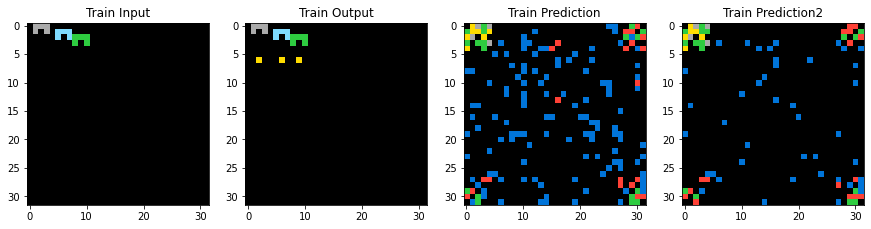

In [48]:
cmap = colors.ListedColormap(
            ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
             '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)
fig, ax = plt.subplots(1, 4, figsize=(15,15))
ax[0].imshow(v[0], cmap=cmap, norm=norm)
ax[0].set_title('Train Input')
ax[1].imshow(y, cmap=cmap, norm=norm)
ax[1].set_title('Train Output')
ax[2].imshow(new_arr[0], cmap=cmap, norm=norm)
ax[2].set_title('Train Prediction')
ax[3].imshow(arr, cmap=cmap, norm=norm)
ax[3].set_title('Train Prediction2');

In [49]:
i = 0
c = 0
for task in Xs_train_orig:
    i+=1
    j = 0
    for e in task:
        j+=1
        c += 1
        if c > 124:
            break
    if c > 124:
        break

In [50]:
i,j

(40, 3)

In [51]:
 ww = (np.array(Xs_train_tasks[40][0]).reshape(32,32))*10

In [52]:
ww

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 3., 0., ..., 0., 0., 0.],
       [0., 0., 3., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [53]:
vv = (np.array(ys_train_tasks[40][0]).reshape(32,32))*10

In [54]:
tt = ww.reshape(1,32,32,1)

In [55]:
encoded_imgs = base_model.encoder(tt).numpy()
decoded_imgs = base_model.decoder(encoded_imgs).numpy()

In [56]:
arr=(decoded_imgs[0].reshape(32,32))*10

In [57]:
arr[:10,:10].shape

(10, 10)

In [58]:
np.asarray(Xs_train_orig[40][0]).shape, np.asarray(ys_train_orig[40][0]).shape

((10, 10), (10, 10))

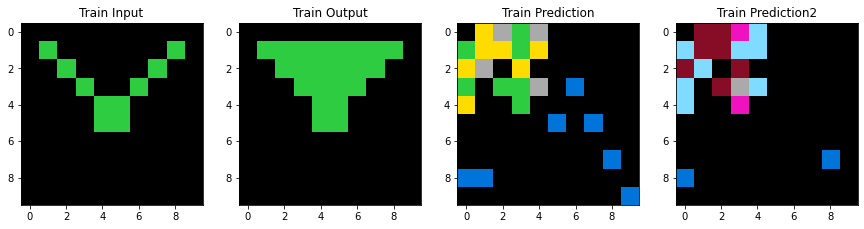

In [59]:
cmap = colors.ListedColormap(
            ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
             '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)
fig, ax = plt.subplots(1, 4, figsize=(15,15))
ax[0].imshow(ww[:10,:10], cmap=cmap, norm=norm)
ax[0].set_title('Train Input')
ax[1].imshow(vv[:10,:10], cmap=cmap, norm=norm)
ax[1].set_title('Train Output')
ax[2].imshow(new_arr[0][:10,:10], cmap=cmap, norm=norm)
ax[2].set_title('Train Prediction')
ax[3].imshow(arr[:10,:10], cmap=cmap, norm=norm)
ax[3].set_title('Train Prediction2');